![Cardio Image](https://www.salud.mapfre.es/media/2016/07/claves-para-mantener-un-coraz%C3%B3n-sano-1100x408.jpg)
<h1>Cardio Catch Diseases SA</h1>

## 0.0 - Planning and Business Knowledge

<h4>Objective</h4>
    <li>Growth diagnostic precision and make stable.</li>


<h4>Justification</h4>
    <li>Manager Instruction Guideline click <a href="https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/">HERE</a></li>
    <li>Currently, it's a manual diagnostic by humans.</li>
    <li>Low Precision, between 55% and 65%.</li>
    <li>Hight cost around one thousand (1.000,00) Reals with operators and machines costing.</li>
    <li>The revenue is variable accordingly precision from diagnostics, 500 each 5% above than 50% precision.</li>
    
<h4>Solution Proposal</h4>
    <lu>
        <li>Collect data from <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">Kaggle</a></li>
        <li>Build a binary classification with <b>Machine Learning</b> or <b>statistics models</b> solution to diseases prediction.</li>
    </lu>
    
<h4>Report</h4>
    <lu>
        <li>What the precision accuracy from the solution?.</li>
        <li>How much profit you will get because of that solution?</li>
        <li>how reliable is the solution?</li>
    </lu>
    
<h4>Planning Chronogram</h4>

![Planning](https://gitlab.com/datascience-community/pa001_cardio_catch_diseases/uploads/82b6018ae2ad3fa508b17b1026c6c1eb/Captura_de_tela_de_2020-09-18_11-22-01.png)

## 1.0 - Imports

### 1.1 - Libraries

In [2]:
# Manipulation
import pandas as pd
import numpy as np
import inflection 
import datetime
from random import sample as sp

# Database CRUD
from sqlalchemy import create_engine
import sqlite3

# Data Transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr


# Machine Learning, selection and split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
import pickle
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


#Configurations
from IPython.display import Image
from IPython.display import HTML
import warnings

### 1.2 - Funcions

In [98]:
# Engine
def engine_db():
    engine_db = create_engine("sqlite:////home/python/Documents/Projects/pa001_cardio_catch_diseases/ccd.db", echo=False)
    return engine_db


# Insert dataframe to database
def insert_database_values(data_frame):
    engine = engine_db()
    data_frame.to_sql('patients', con=engine, if_exists='append', index=False)


# Calculating Scores to classification 
def metrics_score(y_valid, y_hat, mdl_name:str, transform_before_split:bool, obs:str):
    '''
        y_hat:    is the prediction array
        y_valid:  is the true targe array or series
        mdl_name: is the name of machine learning model
        transform_before_split: If True it was transformation before of Split else False 
        obs:      is to any observation that you want to write
        
        positive_true  = (y_hat[y_hat == y_valid] == 1).sum()
        positive_false = (y_hat[y_hat != y_valid] == 1).sum()
        negative_false = (y_hat[y_hat != y_valid] == 0).sum()
        
        Accuracy formula  -->   accuracy   = np.mean(y_hat == y_valid)
        Precision formula -->   precision  = positive_true/(positive_true+positive_false)      
        Recall formula    -->   recall     = positive_true/(positive_true+negative_false)
        
        Return -->> mdl_name, accuracy, precision, recall, transform_before_split, datetime.date.today(), obs
        
        See more: https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-
        acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c
        
        By: Diego Poleto Mayer
        Email: diegopmayer@gmail.com
    
    '''
    accuracy = accuracy_score(y_valid, y_hat)
    precision = precision_score(y_valid, y_hat)
    recall = recall_score(y_valid, y_hat)
    
    return pd.DataFrame([[mdl_name, accuracy, precision, recall, 
                        transform_before_split, datetime.date.today(), obs]], 
                        columns=['mdl_name', 'accuracy', 'precision', 'recall', 
                                 'split_before_scaling', 'date', 'obs'])
    
    #return mdl_name, accuracy, precision, recall, transform_before_split, datetime.date.today(), obs


# Calculating phi to correlation between two dichotomous variables
def phi_correlation(col1, col2):

	'''

        The phi coefficient it's to correlation between dichotomous vs dichotomous. 
        col1, col2 must be dichotomous variables.

    '''

	table = pd.crosstab(col1, col2, margins=True)

	a = table.iloc[0, 0]
	b = table.iloc[0, 1]
	c = table.iloc[1, 0]
	d = table.iloc[1, 1]
	r_1 = table.iloc[0, 2]
	r_2 = table.iloc[1, 2]
	c_1 = table.iloc[2, 0]
	c_2 = table.iloc[2, 1]

	phi = round((a * d - b * c) / math.sqrt(r_1 * r_2 * c_1 * c_2), 2)

	return sns.heatmap(pd.DataFrame({col1.name:phi}, index=[col2.name]), annot=True)


# Jupyter configuring to better experience
def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,9]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

# To hide warning messages
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


### 1.3 - Data Collect

#### 1.2.1 - Data Collect - CSV

In [122]:
# Loading dataset
df_train = pd.read_csv('/home/python/Documents/Projects/pa001_cardio_catch_diseases/datasets/cardio_train.csv', sep=';')

# Test split
# df_train, df_test = train_test_split(df_train)

#### 1.2.2 - Creating Datawerehouse

##### 1.2.2.1 - Rename Columns

In [123]:
# Old columns
df_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [124]:
# Rewriting columns names and replace then
new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
       'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']
df_train.columns = new_col
df_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'hight_pressure',
       'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active',
       'cardio'],
      dtype='object')

##### 1.2.2.2 - Database

In [131]:
# creating database
conn = sqlite3.Connection('ccd.db')
cursor = conn.cursor()

# create table
query = '''CREATE TABLE IF NOT EXISTS patients(
                                id INTEGER,
                                age INTEGER,
                                gender INTEGER,
                                height INTEGER,
                                weight INTEGER,
                                hight_pressure INTEGER,
                                low_pressure INTEGER,
                                cholesterol INTEGER,
                                glucose INTEGER,
                                smoker INTEGER,
                                alcohol INTEGER,
                                active INTEGER,
                                cardio INTEGER
                                )'''

cursor.execute(query)

# insert values from functions
if not engine.execute('SELECT * FROM patients').fetchall():
    insert_database_values(df_train)
    print('Values Inserted')
else:
    print('Continue')

Continue


#### 1.2.3 - Data Collect from Database

In [132]:
# Selecting data
engine = engine_db()
select_data = engine.execute('SELECT * FROM patients').fetchall()

# Converting to Dataframe
df_train = pd.DataFrame(select_data, columns=df_train.columns)
print(df_train.shape)
df_train.head()

(70000, 13)


,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2.0 - Descriptive Analysis

### 2.1 - Dimensions

In [14]:
# Printing the data dimensions, how much rows and columns
print(f'{df_train.shape[0]} linhas.')
print(f'{df_train.shape[1]} colunas.')

70000 linhas.
13 colunas.


### 2.2 - Datatype and NaN fillout

In [17]:
# Columns Datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              70000 non-null  int64  
 1   age             70000 non-null  int64  
 2   gender          70000 non-null  int64  
 3   height          70000 non-null  int64  
 4   weight          70000 non-null  float64
 5   hight_pressure  70000 non-null  int64  
 6   low_pressure    70000 non-null  int64  
 7   cholesterol     70000 non-null  int64  
 8   glucose         70000 non-null  int64  
 9   smoker          70000 non-null  int64  
 10  alcohol         70000 non-null  int64  
 11  active          70000 non-null  int64  
 12  cardio          70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [18]:
# Crossing datatypes with data meanings.
df_train.sample(5)

,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio
68859,98378,22550,1,150,63.0,120,80,1,1,0,0,1,1
38528,55018,20454,1,165,65.0,130,80,1,1,0,0,1,1
65782,93889,15406,1,156,60.0,110,70,1,1,0,0,1,0
532,766,16729,1,169,73.0,120,80,1,1,0,0,0,1
65560,93573,22401,2,163,87.0,130,90,1,1,0,0,1,0


In [19]:
# age - change days to year old
df_train['age'] = (df_train['age'] / 365).astype('int')

# height - change centimeters to meters
df_train['height'] = (df_train['height'] / 100)

# NaN and fill out
df_train.isnull().sum()
## There aren't NaN

id                0
age               0
gender            0
height            0
weight            0
hight_pressure    0
low_pressure      0
cholesterol       0
glucose           0
smoker            0
alcohol           0
active            0
cardio            0
dtype: int64

### 2.3 - Data Description

In [20]:
# Descriptive statistics
describe = df_train.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['kurtosis'] = describe.T.kurtosis()
describe['skew'] = describe.T.skew()
describe

,count,mean,std,min,25%,50%,75%,max,range,kurtosis,skew
age,70000.0,52.840671,6.766774,29.00,48.00,53.00,58.0,64.0,35.00,8.999985,3.162273
gender,70000.0,1.349571,0.476838,1.00,1.00,1.00,2.0,2.0,1.00,9.000000,3.162278
height,70000.0,1.643592,0.082101,0.55,1.59,1.65,1.7,2.5,1.95,9.000000,3.162278
weight,70000.0,74.205690,14.395757,10.00,65.00,72.00,82.0,200.0,190.00,8.999790,3.162222
hight_pressure,70000.0,128.817286,154.011419,-150.00,120.00,120.00,140.0,16020.0,16170.00,6.726216,2.681020
low_pressure,70000.0,96.630414,188.472530,-70.00,80.00,80.00,90.0,11000.0,11070.00,7.897989,2.922091
cholesterol,70000.0,1.366871,0.680250,1.00,1.00,1.00,2.0,3.0,2.00,9.000000,3.162278
glucose,70000.0,1.226457,0.572270,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
smoker,70000.0,0.088129,0.283484,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278
alcohol,70000.0,0.053771,0.225568,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278


There are some inconsistent numbers of **hight pressure** and **low pressure** and you will be drop this, because it's little quantity

In [21]:
# How much errors on arterial pressure?
print(f'''{df_train[(df_train['low_pressure'] < 20) | (
    df_train['low_pressure'] > 150)].shape[0]} inconsistent rows on low_pressure.''')
print(f'''{df_train[(df_train['hight_pressure'] < 40) | (
    df_train['hight_pressure'] > 300)].shape[0]} inconsistent rows on hight_pressure. ''')
print(f'''{df_train[df_train['height'] <= 1.45].shape[0]} inconsistent rows on height.''')

1013 inconsistent rows on low_pressure.
228 inconsistent rows on hight_pressure. 
520 inconsistent rows on height.


In [22]:
# filtering data without inconsistence data
df_train = df_train[(df_train['low_pressure'] >= 20) & (df_train['low_pressure'] <= 150)]
df_train = df_train[(df_train['hight_pressure'] >= 40) & (df_train['hight_pressure'] <= 300)]

# Data filtering possible incosistent data by height 
df_train = df_train[df_train['height'] > 1.45]

# Inconsistent data by weight
df_train = df_train[df_train['weight'] > 43]

In [23]:
# Descriptive statistics
describe = df_train.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['kurtosis'] = describe.T.kurtosis()
describe['skew'] = describe.T.skew()
describe

,count,mean,std,min,25%,50%,75%,max,range,kurtosis,skew
age,68066.0,52.818838,6.762977,29.00,48.00,53.00,58.0,64.0,35.00,8.999985,3.162273
gender,68066.0,1.351394,0.477409,1.00,1.00,1.00,2.0,2.0,1.00,9.000000,3.162278
height,68066.0,1.646068,0.076629,1.46,1.59,1.65,1.7,2.5,1.04,9.000000,3.162278
weight,68066.0,74.276853,14.157654,44.00,65.00,72.00,82.0,200.0,156.00,8.999840,3.162233
hight_pressure,68066.0,126.637381,16.708953,60.00,120.00,120.00,140.0,240.0,180.00,8.999796,3.162214
low_pressure,68066.0,81.360753,9.590499,20.00,80.00,80.00,90.0,150.0,130.00,8.999899,3.162248
cholesterol,68066.0,1.364367,0.678866,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
glucose,68066.0,1.226060,0.572088,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
smoker,68066.0,0.088620,0.284196,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278
alcohol,68066.0,0.053845,0.225713,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278


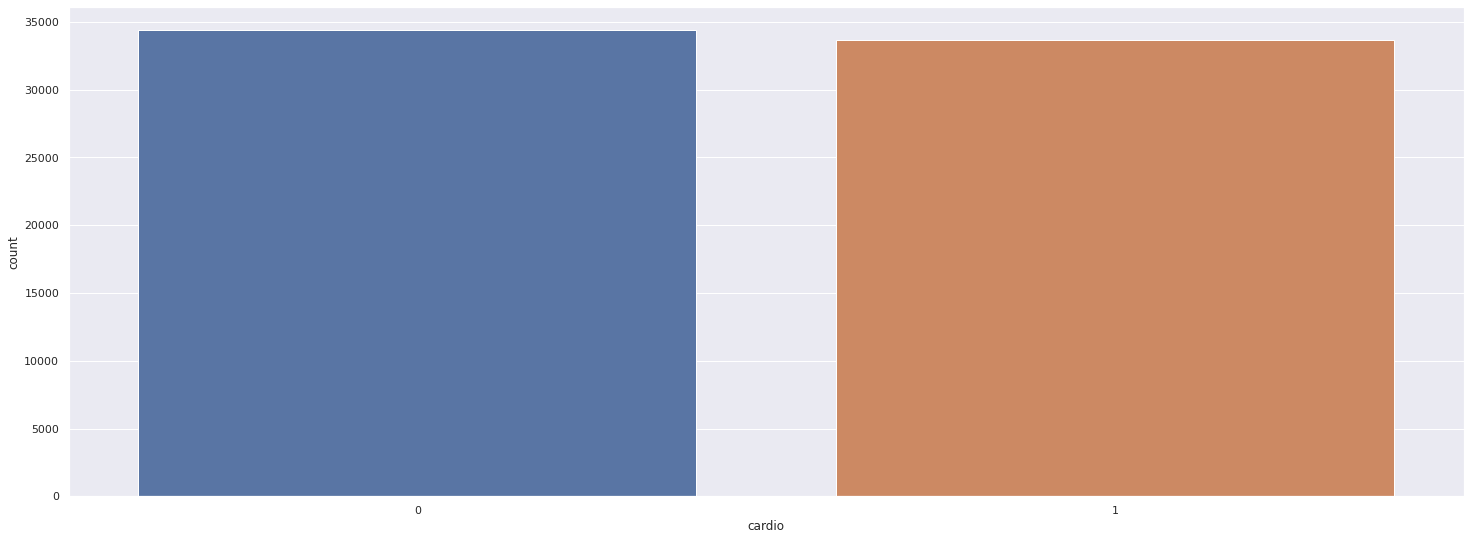

In [24]:
sns.countplot(df_train['cardio']);

## 3.0 - Feature Engineering

In [25]:
df_train.head()

,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio
0,0,50,2,1.68,62.0,110,80,1,1,0,0,1,0
1,1,55,1,1.56,85.0,140,90,3,1,0,0,1,1
2,2,51,1,1.65,64.0,130,70,3,1,0,0,0,1
3,3,48,2,1.69,82.0,150,100,1,1,0,0,1,1
4,4,47,1,1.56,56.0,100,60,1,1,0,0,0,0


A differene between systolic and diastolic arterial pressure, if it's lesser than 30mmhg called convergent and upper than 60mmhg called divergent and both cases they are corretion with cardiac diseases
<a href="https://enfermagemilustrada.com/pressao-arterial-divergente-e-convergente/">Norse Site</a> and <a href="https://drleonardoalves.com.br/pressao-arterial-convergente-o-que-e-2/">Doctor Site Article</a>.

In [26]:
df_train['difference'] = df_train['hight_pressure'] - df_train['low_pressure']
df_train['convergent'] = df_train['difference'].apply(lambda x: 1 if x <= 30 else 0)
df_train['divergent'] = df_train['difference'].apply(lambda x: 1 if x >= 60 else 0)

Other important feature is BMI where it's possible correlation with cardiac diseases because of obesity<a href="https://centrodeobesidadeediabetes.org.br/tudo-sobre-obesidade/calculadora-de-imc/#:~:text=Compartilhar%3A,ao%20quadrado%20(em%20metros)."> BMI calc</a>

In [27]:
# BMI calculus and slices in four levels
df_train['bmi'] = (df_train['weight']/(df_train['height'] * df_train['height']))
df_train['bmi_level'] = df_train['bmi'].apply(lambda x: 
                                              'underweight' if x <= 18.5 else
                                              'normal'      if x >  18.5 and x <= 24.9 else
                                              'overweight'  if x >= 25.0 and x <= 29.9 else
                                              'obesity')

In [28]:
# Hypertension and Hipotension binary
df_train['hypertension'] = df_train.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
df_train['hypotension'] = df_train.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)

In [29]:
# Slicing ages with three ranges
df_train['age_range'] = df_train['age'].apply(lambda x: 'age_0_50'    if x <= 50 
                                                   else 'age_51_59'   if x >= 51 and x <= 59 
                                                   else 'age_60_over' if x >= 60 
                                                   else x)

In [30]:
df_train['weight_range'] = df_train['weight'].apply(
    lambda x:   0.50 if x <= 50  else
                0.75 if x >= 51  and x <= 75 else
                1.00 if x >= 76  and x <= 100 else
                1.25 if x >= 101 and x <= 125 else
                1.50 if x >= 126 and x <= 150 else
                1.75 if x >= 151 and x <= 175 else 2.00)

## 4.0 - Data Filtering

In [31]:
df_train.head()

,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio,difference,convergent,divergent,bmi,bmi_level,hypertension,hypotension,age_range,weight_range
0,0,50,2,1.68,62.0,110,80,1,1,0,0,1,0,30,1,0,21.967120,normal,0,0,age_0_50,0.75
1,1,55,1,1.56,85.0,140,90,3,1,0,0,1,1,50,0,0,34.927679,obesity,0,0,age_51_59,1.00
2,2,51,1,1.65,64.0,130,70,3,1,0,0,0,1,60,0,1,23.507805,normal,0,0,age_51_59,0.75
3,3,48,2,1.69,82.0,150,100,1,1,0,0,1,1,50,0,0,28.710479,overweight,0,0,age_0_50,1.00
4,4,47,1,1.56,56.0,100,60,1,1,0,0,0,0,40,0,0,23.011177,normal,0,0,age_0_50,0.75


In [32]:
# Data Filtering rows, values or columns
df_train = df_train.drop('id', axis=1)

In [33]:
df_train.shape

(68066, 21)

## 5.0 - EDA - Explolatory Data Analysis

### 5.1 - Hypothesis MindMap

In [34]:
ls

pa001_cardio_catch_diseases_diego_mayer_c01.ipynb
pa001_cardio_catch_diseases_diego_mayer_c02.ipynb
pa001_cardio_catch_diseases_diego_mayer_c03.ipynb


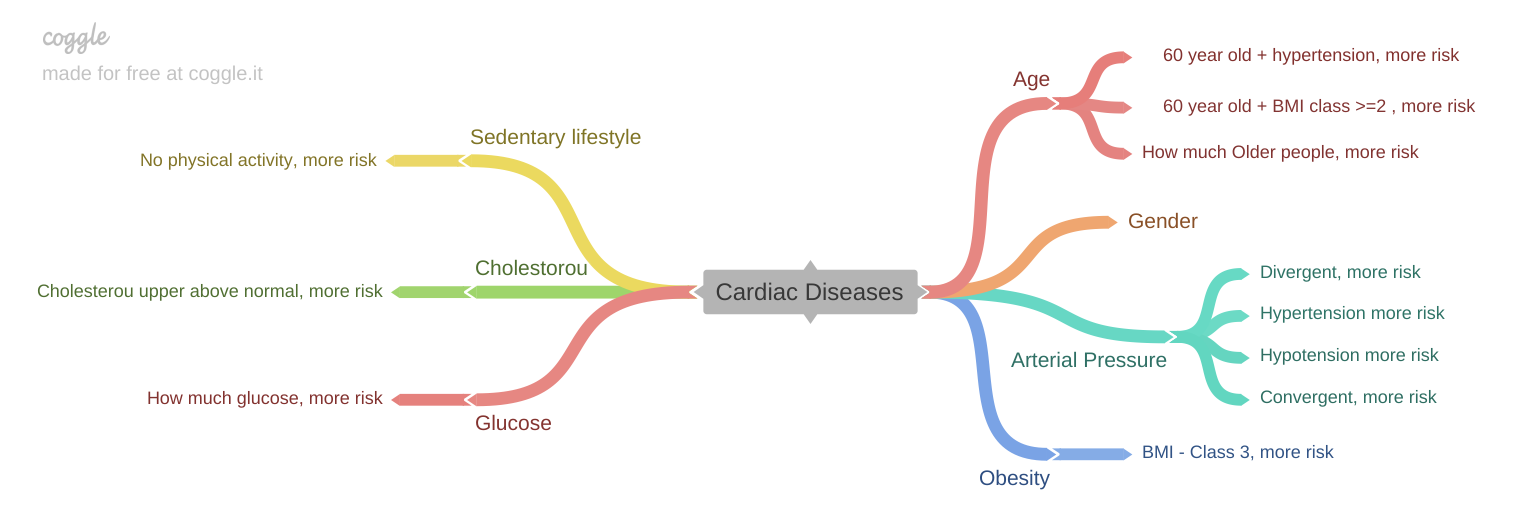

In [35]:
Image('/home/python/Documents/Projects/pa001_cardio_catch_diseases/img/mindmap.png')

### 5.2 - Univariate Analysis

#### 5.2.1 - Response Variable

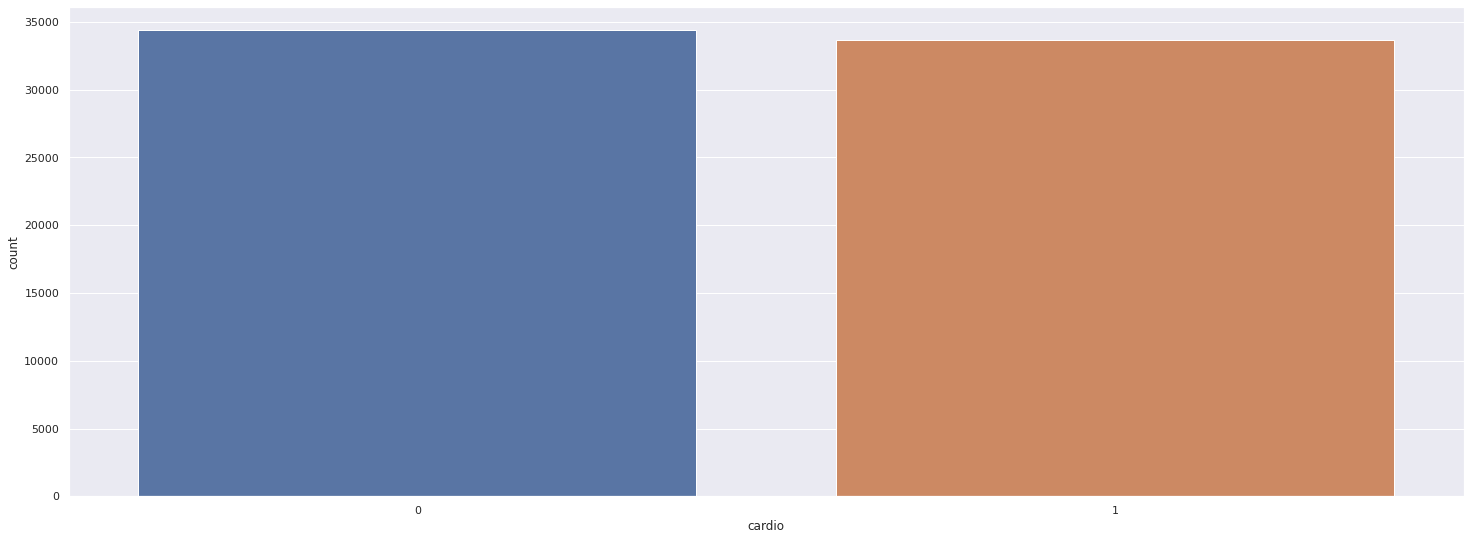

In [36]:
# plotting if diseases or not, this case is balanced
sns.countplot(df_train['cardio']);

#### 5.2.2 - Predictor Variables

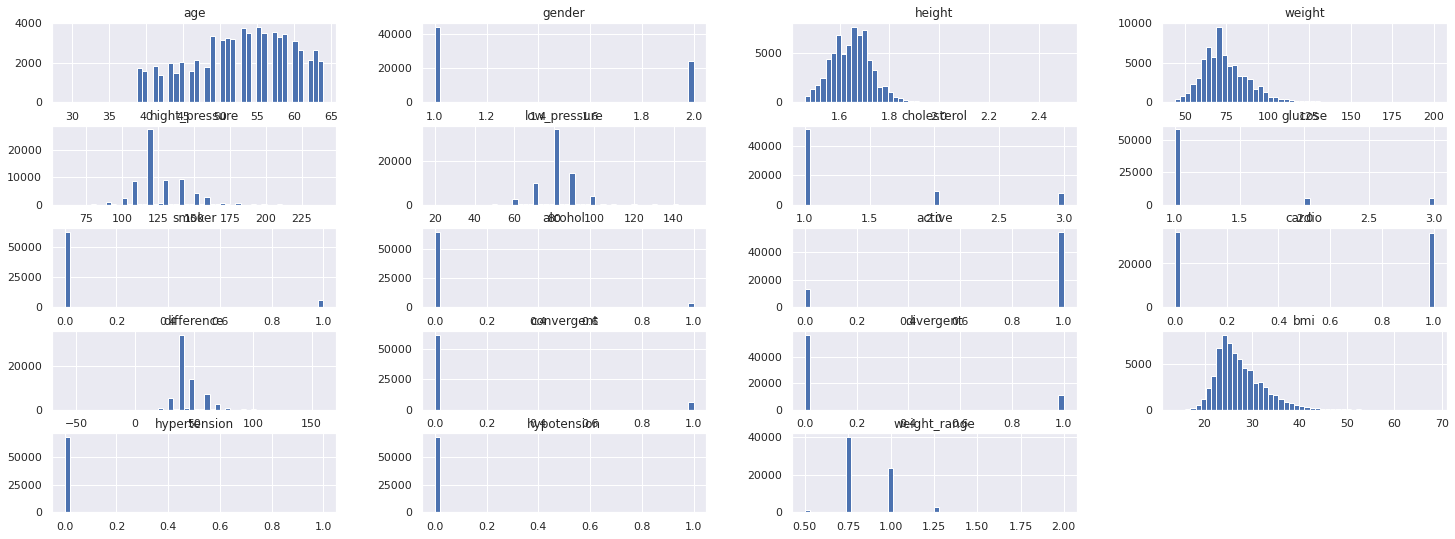

In [37]:
# Distribution from all data
df_train.hist(bins=50);

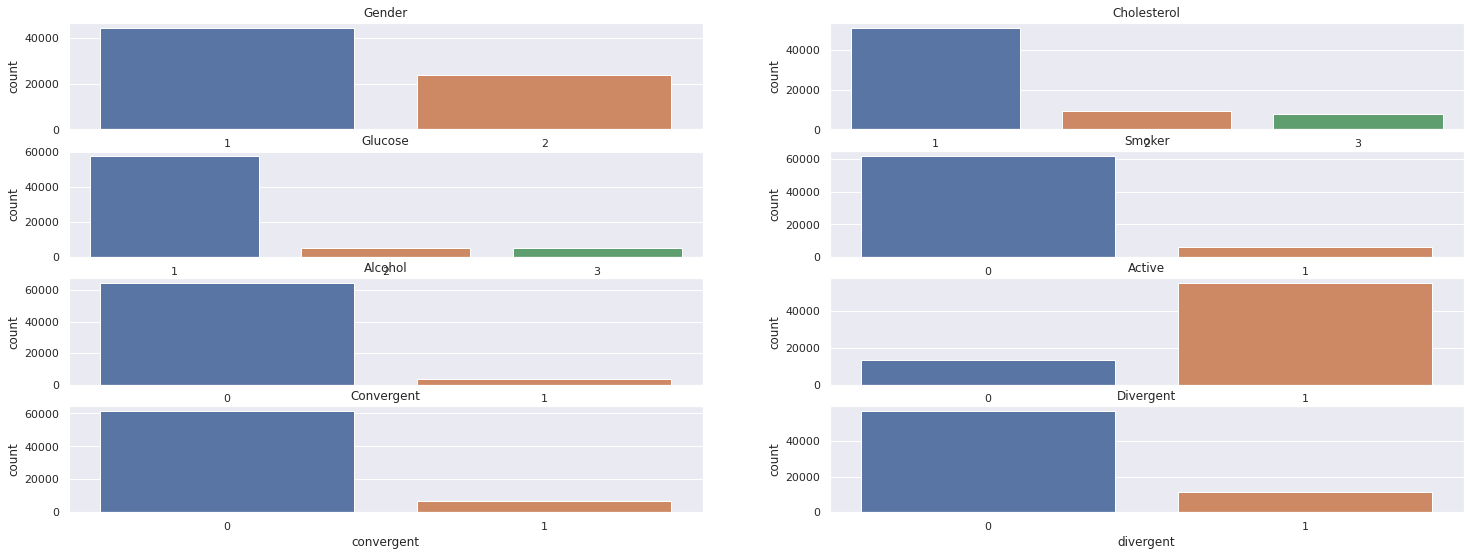

In [38]:
# Categorical Data

grid = GridSpec(4,2)

subplot(grid[0,0])
plt.title('Gender')
sns.countplot(df_train['gender']);

subplot(grid[0,1])
plt.title('Cholesterol')
sns.countplot(df_train['cholesterol']);

subplot(grid[1,0])
plt.title('Glucose')
sns.countplot(df_train['glucose']);

subplot(grid[1,1])
plt.title('Smoker')
sns.countplot(df_train['smoker']);

subplot(grid[2,0])
plt.title('Alcohol')
sns.countplot(df_train['alcohol']);

subplot(grid[2,1])
plt.title('Active')
sns.countplot(df_train['active']);

subplot(grid[3,0])
plt.title('Convergent')
sns.countplot(df_train['convergent']);

subplot(grid[3,1])
plt.title('Divergent')
sns.countplot(df_train['divergent']);

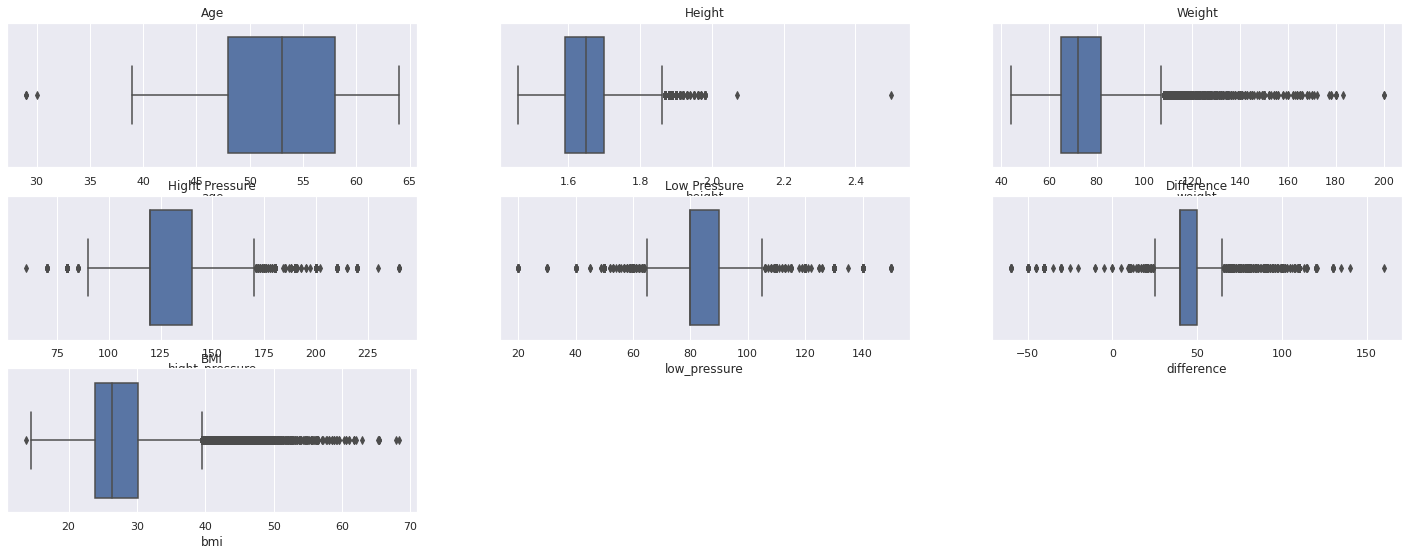

In [39]:
# Numerical Data

grid = GridSpec(3, 3)

subplot(grid[0,0])
plt.title('Age')
sns.boxplot(df_train['age']);

subplot(grid[0,1])
plt.title('Height')
sns.boxplot(df_train['height']);

subplot(grid[0,2])
plt.title('Weight')
sns.boxplot(df_train['weight']);

subplot(grid[1,0])
plt.title('Hight Pressure')
sns.boxplot(df_train['hight_pressure']);

subplot(grid[1,1])
plt.title('Low Pressure')
sns.boxplot(df_train['low_pressure']);

subplot(grid[1,2])
plt.title('Difference')
sns.boxplot(df_train['difference']);

subplot(grid[2,0])
plt.title('BMI')
sns.boxplot(df_train['bmi']);

# Boxplot from numerical data

### 5.3 - Bivariate Analysis

#### 5.5 - Hypothesis Answers

##### 5.2.1 - How more active, less diseases
False

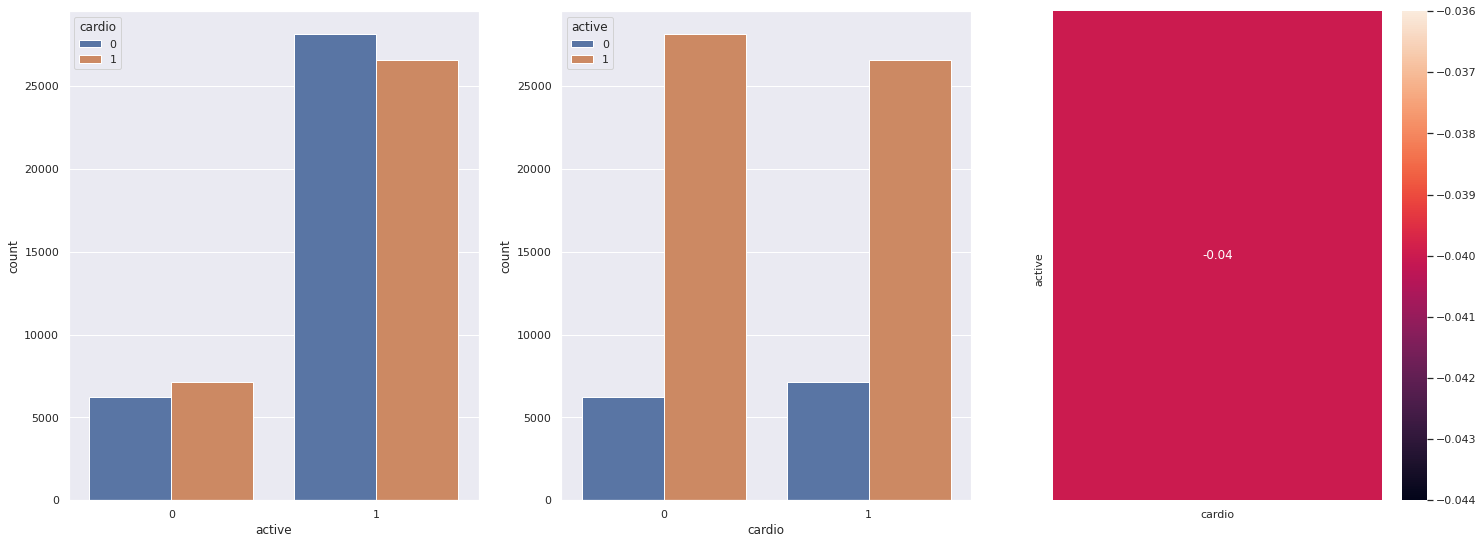

In [40]:
subplot(1,3,1)
sns.countplot(hue='cardio', x='active', data=df_train);

subplot(1,3,2)
sns.countplot(x='cardio', hue='active', data=df_train);

# phi correlation
subplot(1,3,3)
phi_correlation(df_train['cardio'], df_train['active']);

<AxesSubplot:xlabel='active', ylabel='count'>

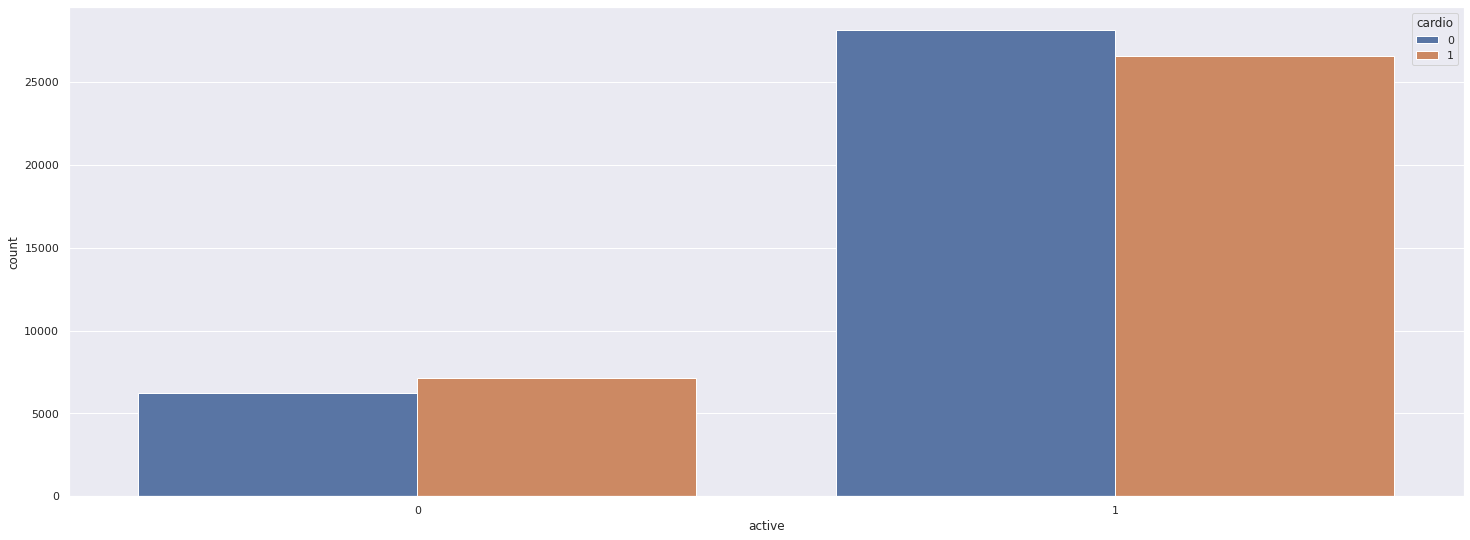

In [41]:
sns.countplot(hue='cardio', x='active', data=df_train)

In [42]:
df_train[['active', 'cardio']].groupby('active').mean()

,cardio
active,
0,0.533333
1,0.485609


##### 5.2.2 - Cholesterou over level I, more risk
   True

How more cholesterol more diseases, see the number 3 it's more disease==positive than negative, the correlation it's low, but it's possible that feature is't important to model

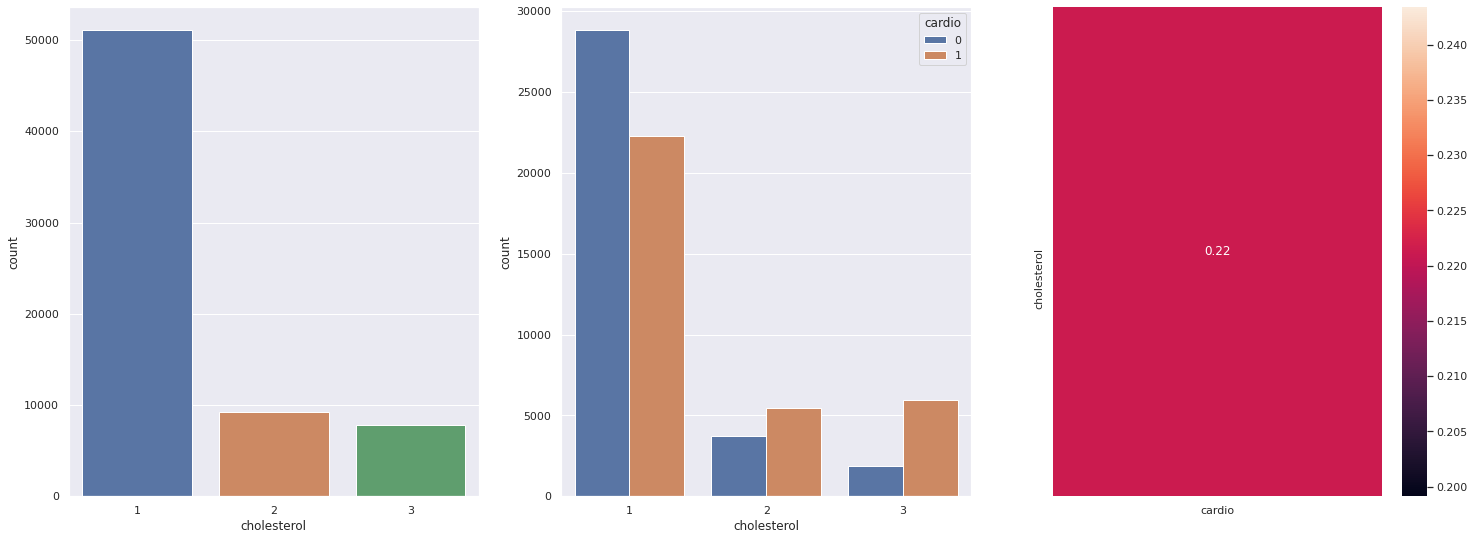

In [43]:
plt.subplot(1,3,1)
sns.countplot(df_train['cholesterol']);

plt.subplot(1,3,2)
sns.countplot(hue='cardio', x='cholesterol', data=df_train);

plt.subplot(1,3,3)
pointb = pointbiserialr(df_train['cardio'], df_train['cholesterol']).correlation
sns.heatmap(pd.DataFrame({'cardio':pointb}, index=['cholesterol']), annot=True);

##### 5.2.3 - How more clucose, more risk
   True

The correlation it's so low, insignificat to model

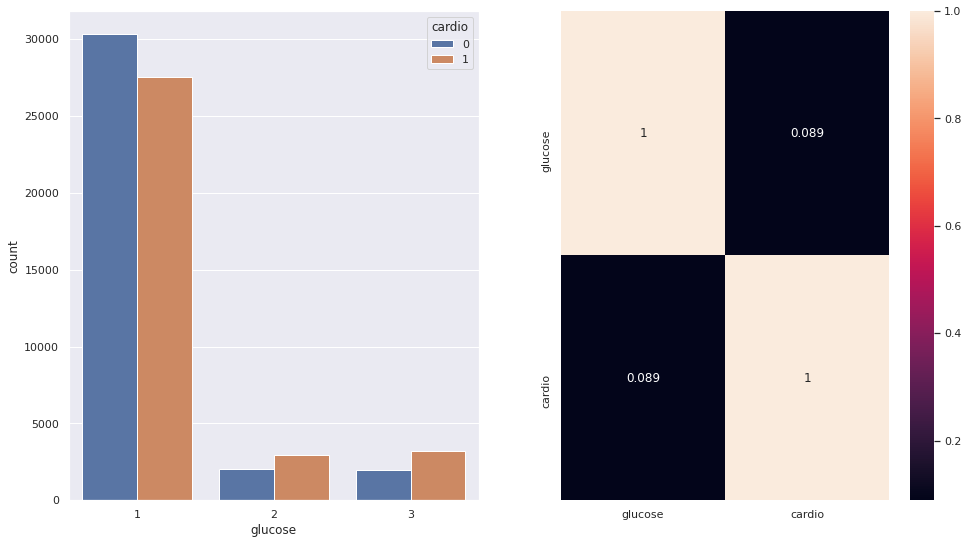

In [44]:
plt.subplot(1,3,1)
sns.countplot(x='glucose', hue='cardio', data=df_train)

plt.subplot(1,3,2)
sns.heatmap(df_train[['glucose', 'cardio']].corr('pearson'), annot=True);

##### 5.2.4 - How more older, more risk
   True

following the years it's more count and more avarage pear year old, low correlation, but, probly it's important to model

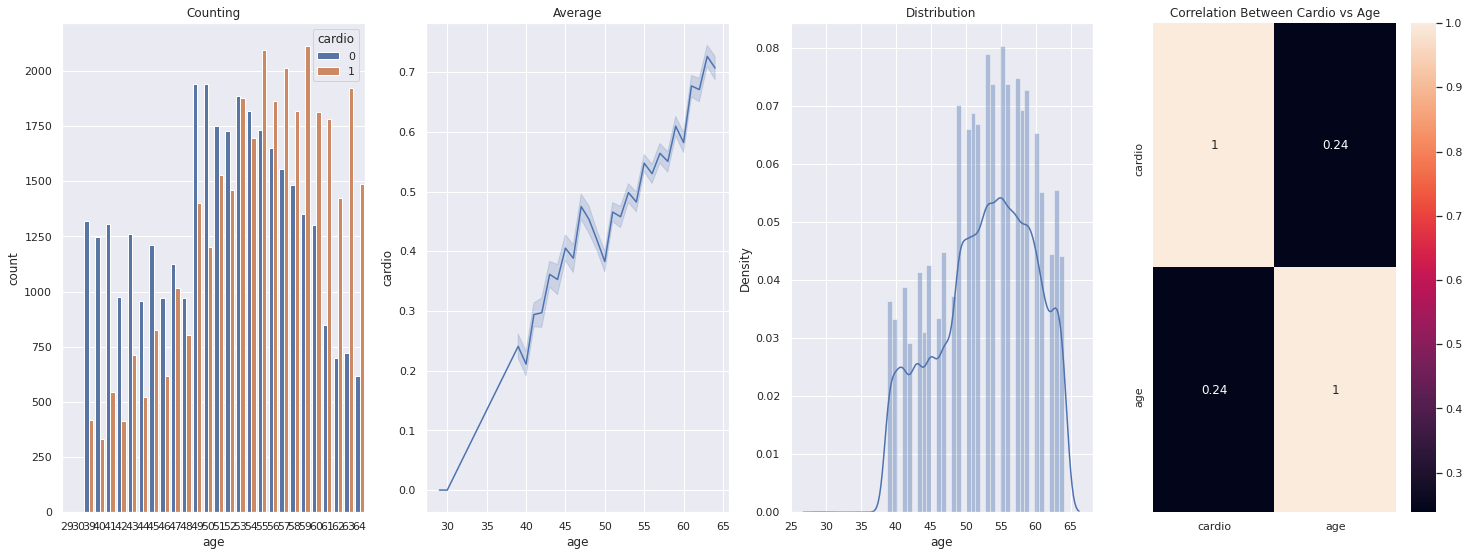

In [45]:
subplot(1,4,1)
plt.title('Counting')
sns.countplot(x='age', hue='cardio', data=df_train);

subplot(1,4,2)
plt.title('Average')
sns.lineplot(data=df_train, x='age', y='cardio', estimator='mean');

subplot(1,4,3)
plt.title('Distribution')
sns.distplot(df_train['age']);

subplot(1,4,4)
plt.title('Correlation Between Cardio vs Age')
sns.heatmap(df_train[['cardio', 'age']].corr('pearson'), annot=True);

##### 5.2.5 - Over 60 year old with Hypertension, more risk
   False

when compare hypertension alone it's more incidence and over 60 alone it's more incidence, but when you group both than it's not more incidence in **averege**.

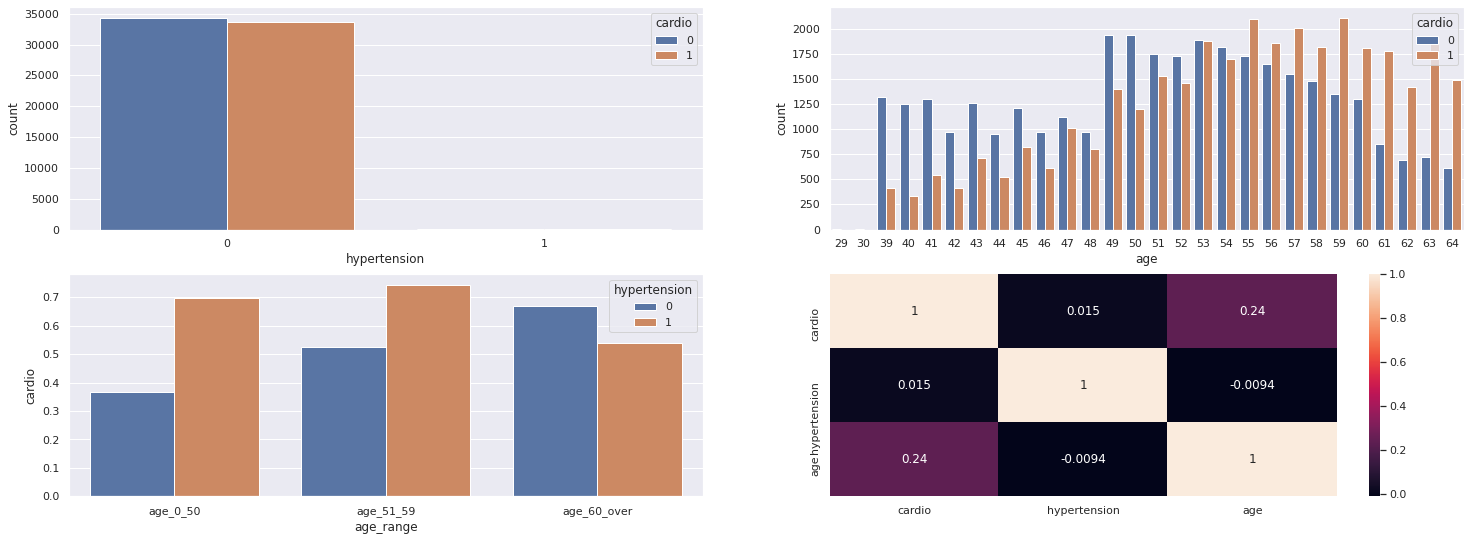

In [46]:
aux = df_train[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df_train[['cardio', 'age_range', 'hypertension']]

plt.subplot(2,2,1)
sns.countplot(hue='cardio', x='hypertension', data=aux1);

plt.subplot(2,2,2)
sns.countplot(x='age', hue='cardio', data=df_train);

# Average incidence of diseases by hypertension and over 60 year.
subplot(2,2,3)
aux = df_train[['hypertension', 'cardio', 'age_range']].groupby(['hypertension', 'age_range']).mean().reset_index()
sns.barplot(x='age_range', y='cardio', hue='hypertension', data=aux);

subplot(2,2,4)
sns.heatmap(df_train[['cardio', 'hypertension', 'age']].corr('pearson'), annot=True);

##### 5.2.6 - 60 year old with Hypotension, more risk
   False

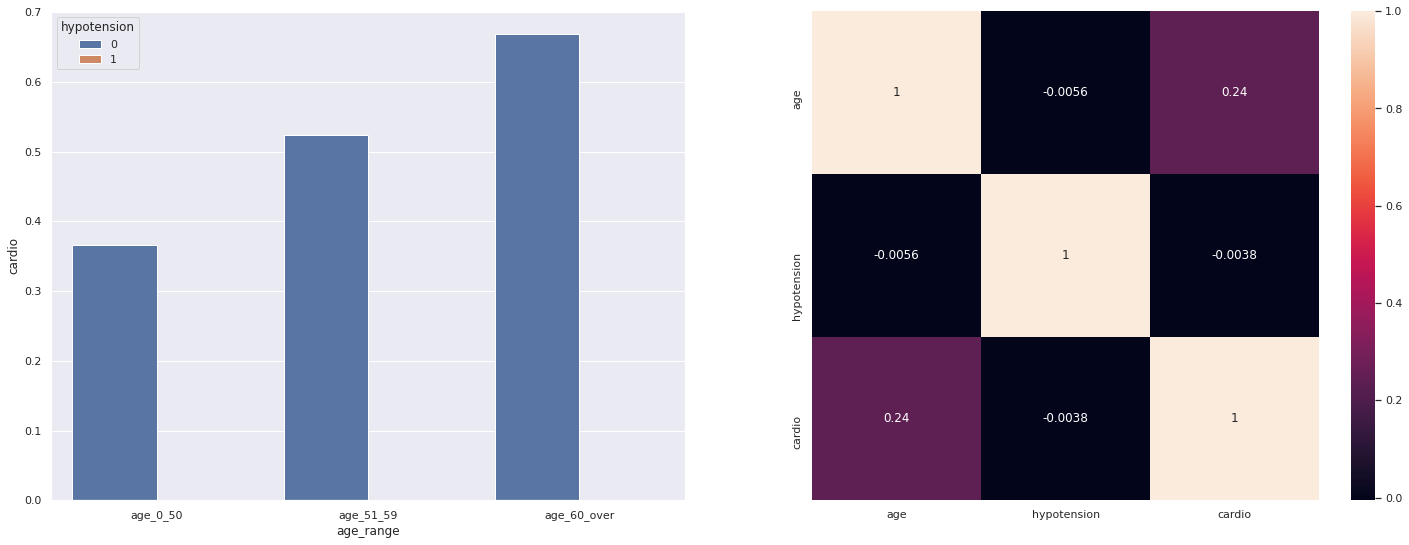

In [47]:
aux = df_train[['hypotension', 'age_range', 'cardio']].groupby(
    ['hypotension', 'age_range']).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='age_range', y='cardio', hue='hypotension', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df_train[['age', 'hypotension', 'cardio']].corr('pearson'), annot=True);

##### 5.2.7 - 60 year old, more risk
   True

The range on 60 year old has a little more incidence of diseases

<AxesSubplot:>

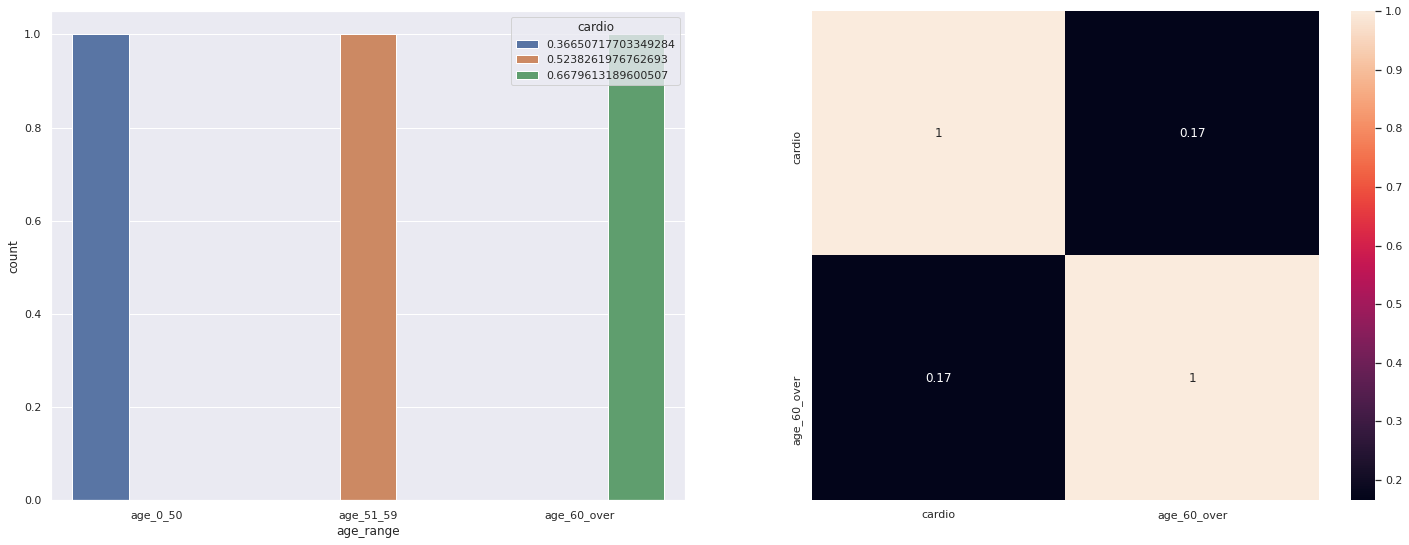

In [48]:
aux = df_train[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df_train[['cardio', 'age_range']]
aux1 = pd.concat([aux1, pd.get_dummies(aux1['age_range'])], axis=1)

plt.subplot(1,2,1)
sns.countplot(x='age_range', hue='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(aux1[['cardio', 'age_60_over']].corr('pearson'), annot=True)

##### 5.2.8 - Divergent AP, more risk
   True - Relevant variable

<AxesSubplot:>

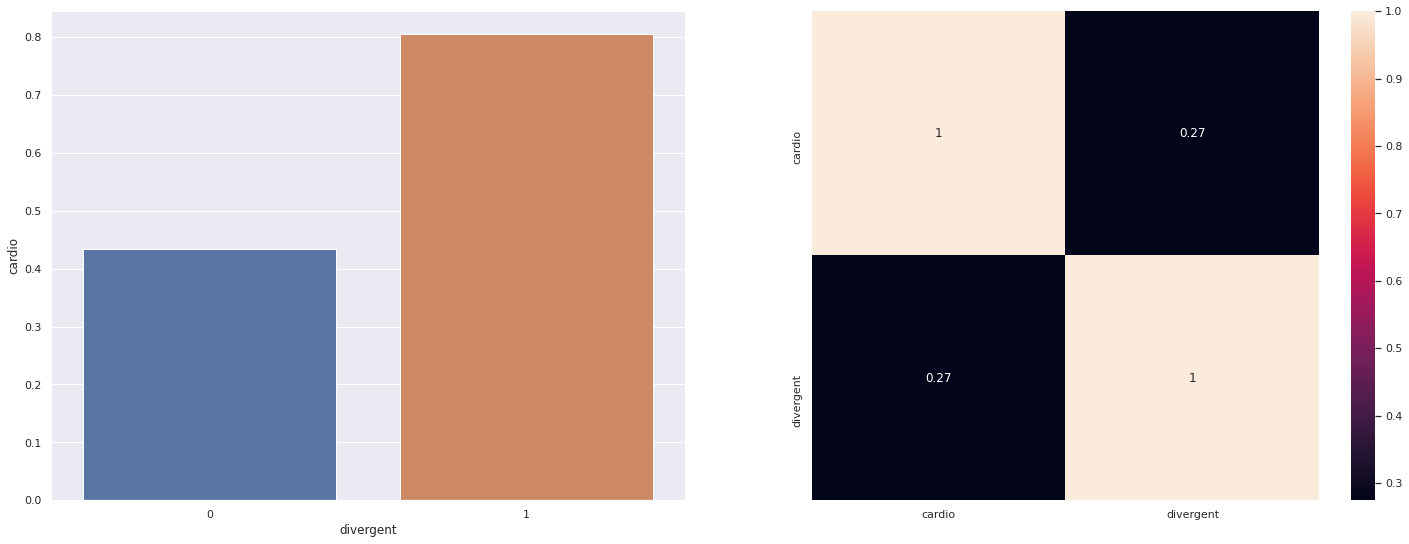

In [49]:
aux = df_train[['divergent', 'cardio']].groupby('divergent').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='divergent', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df_train[['cardio', 'divergent']].corr('pearson'), annot=True)

##### 5.2.9 - Convergent AP, more risk
   False

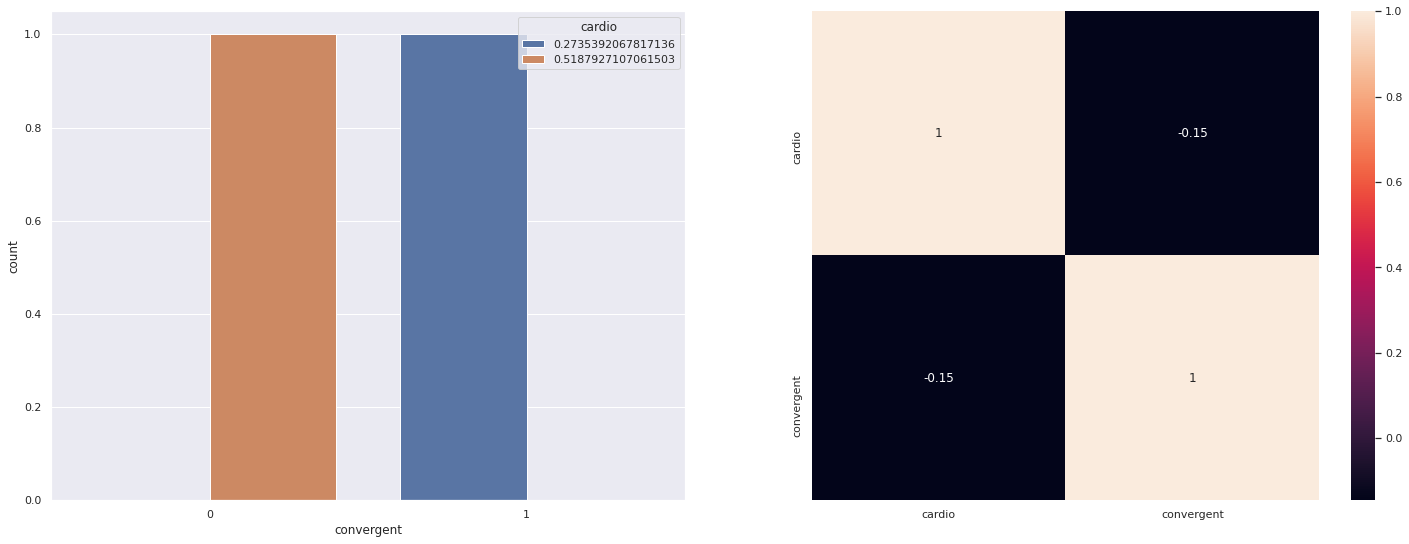

In [50]:
plt.subplot(1,2,1)
sns.countplot(x='convergent', hue='cardio',
    data=df_train[['cardio', 'convergent']].groupby('convergent').mean().reset_index());

plt.subplot(1,2,2)
sns.heatmap(df_train[['cardio', 'convergent']].corr('pearson'), annot=True);

##### 5.2.10 - Hypertension, more risk
   True

Average incidence by Hypertension

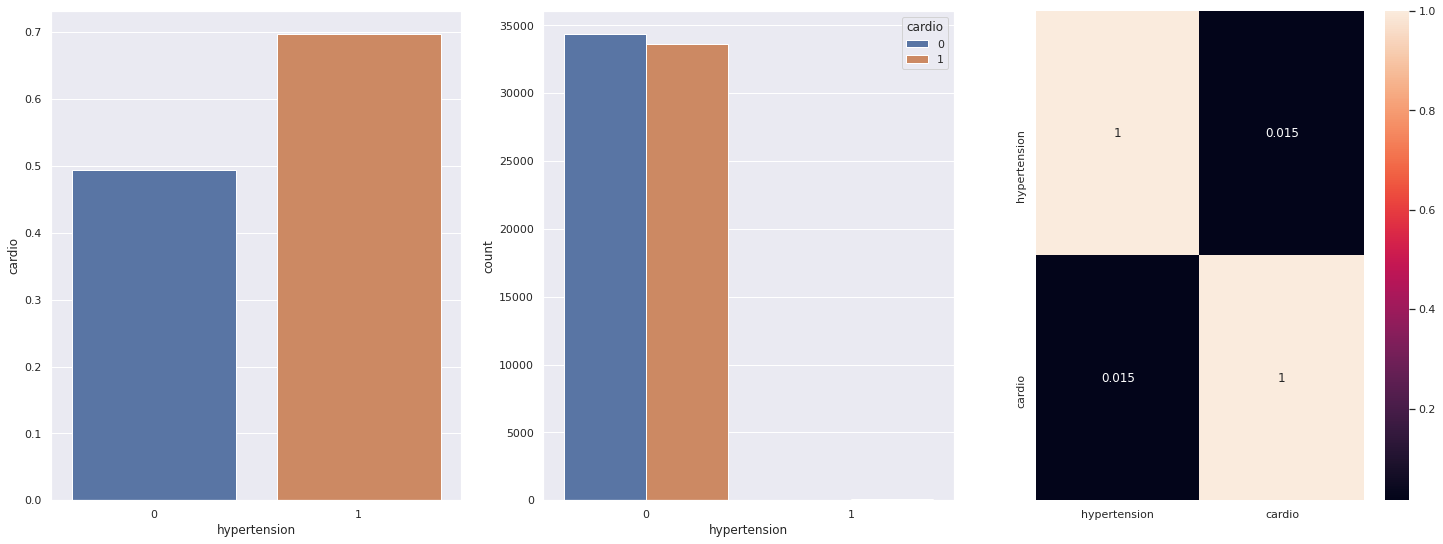

In [51]:
aux = df_train[['hypertension', 'cardio']].groupby('hypertension').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='hypertension', y='cardio', data=aux);

plt.subplot(1,3,2)
sns.countplot(x='hypertension', hue='cardio', data=df_train);

plt.subplot(1,3,3)
sns.heatmap(df_train[['hypertension', 'cardio']].corr('pearson'), annot=True);

In [52]:
# Hypertension percentual
df_train['hypertension'].value_counts()[1] / df_train['hypertension'].value_counts()[0] * 100

0.14565892271249284

##### 5.2.11 - Hypotension, more risk
   False

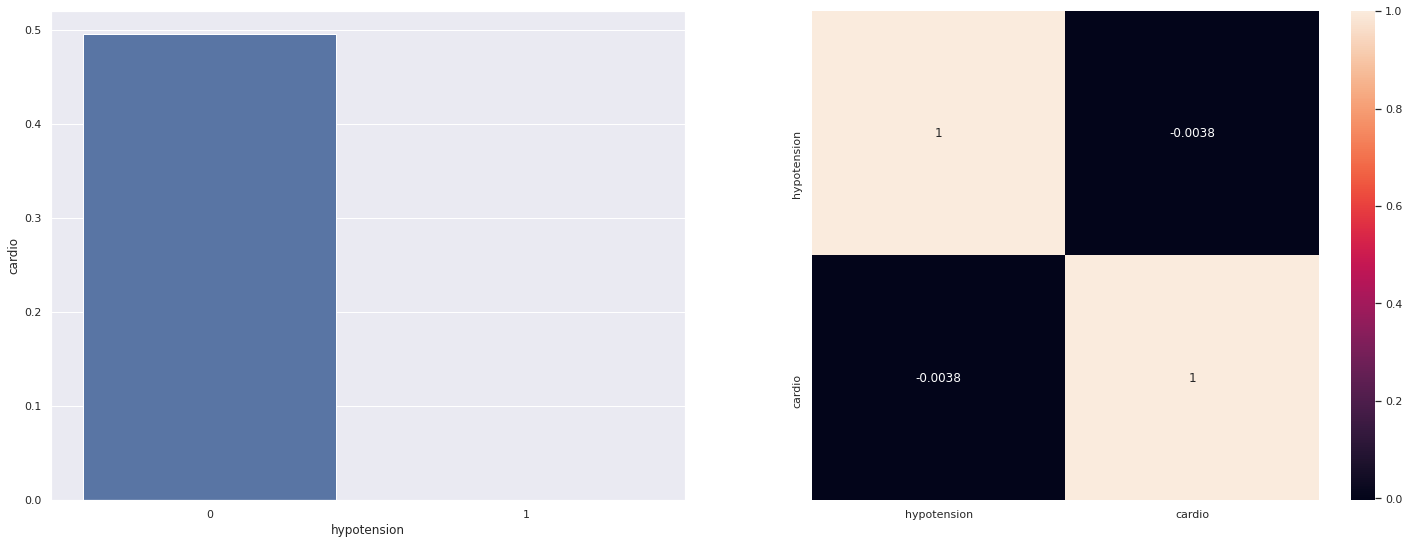

In [53]:
aux = df_train[['hypotension', 'cardio']].groupby('hypotension').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='hypotension', y='cardio', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df_train[['hypotension', 'cardio']].corr('pearson'), annot=True);

In [54]:
df_train['hypotension'].value_counts()

0    68065
1        1
Name: hypotension, dtype: int64

##### 5.2.12 - BMI - Obesity, more risk
   True

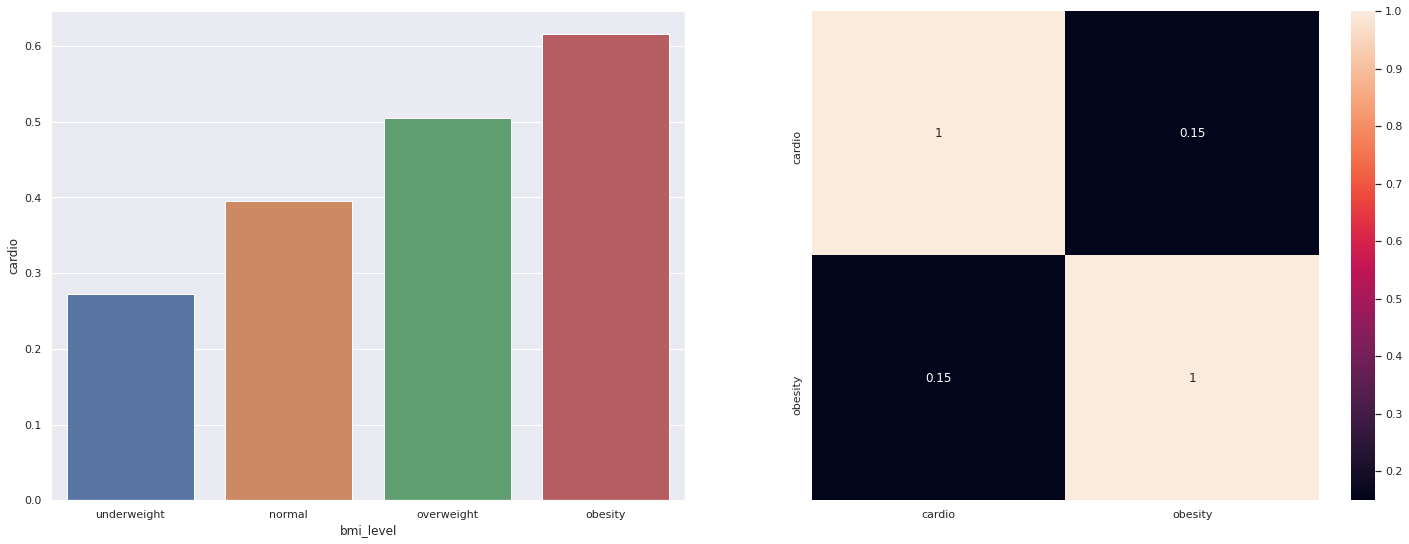

In [55]:
aux = df_train[['bmi_level', 'cardio']].groupby('bmi_level').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='bmi_level', y='cardio', data=aux, order=['underweight', 'normal', 'overweight', 'obesity']);

plt.subplot(1,2,2)
aux1 = df_train.copy()
aux1 = pd.concat([pd.get_dummies(df_train['bmi_level']), aux1], axis=1)
sns.heatmap(aux1[['cardio', 'obesity']].corr('pearson'), annot=True);

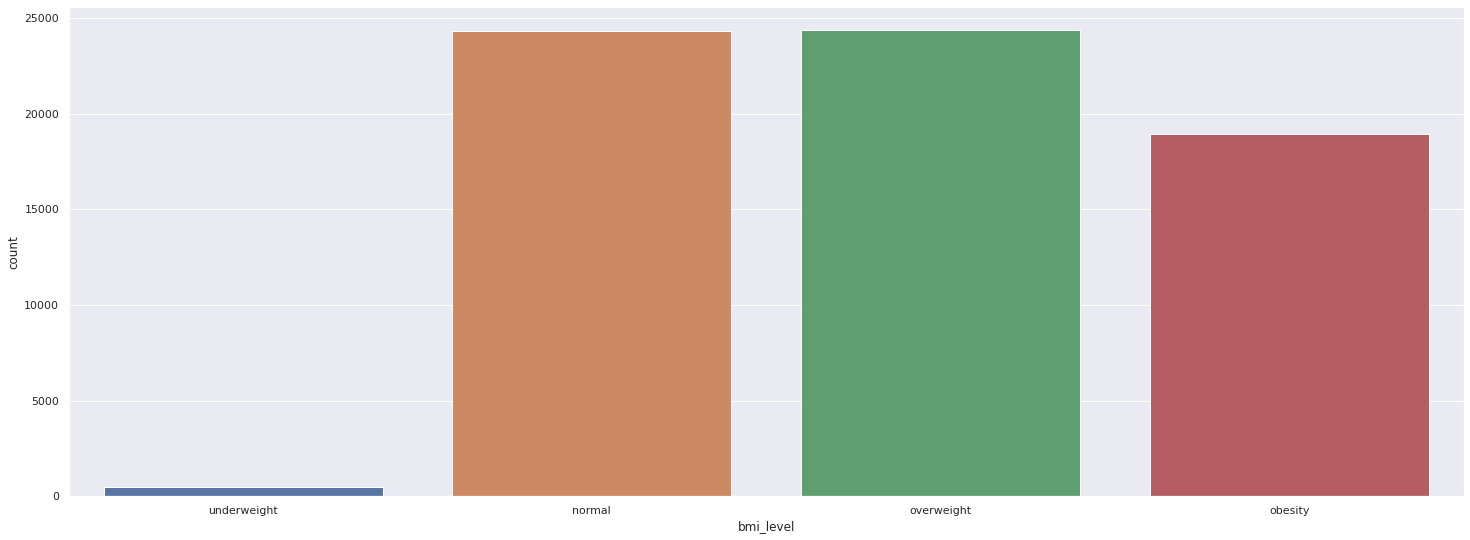

In [56]:
sns.countplot(x='bmi_level', data=df_train, order=['underweight', 'normal', 'overweight', 'obesity']);

##### 5.2.13 - Gender 2 has more risk
   False

<AxesSubplot:>

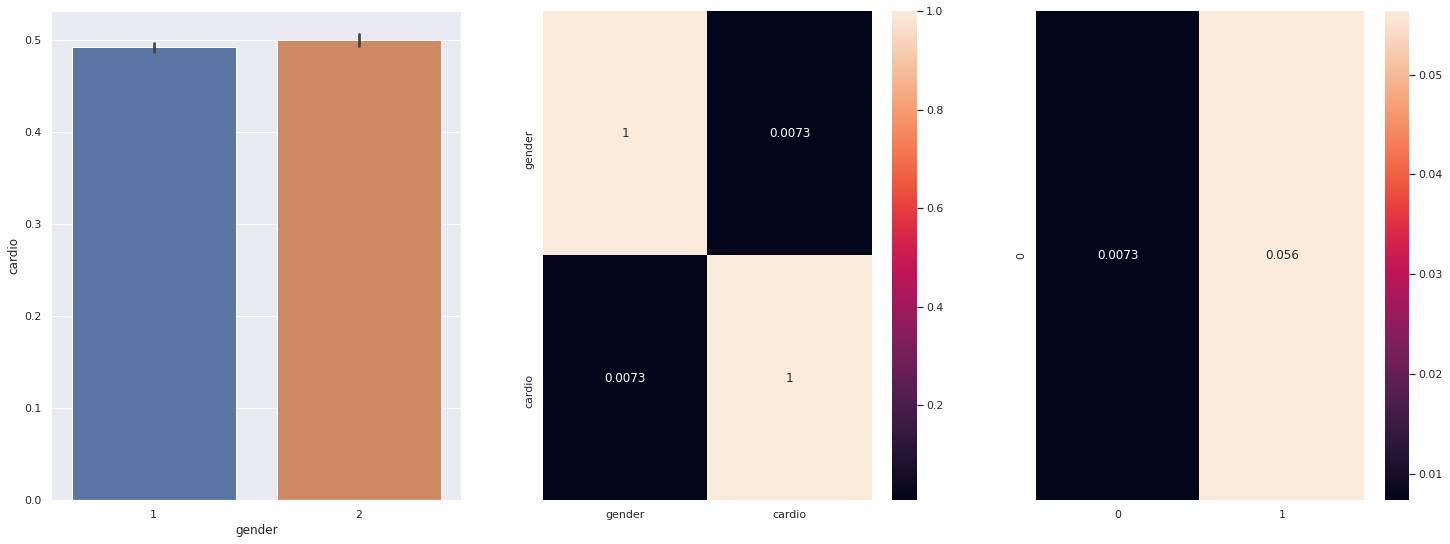

In [57]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='cardio', data=df_train)

plt.subplot(1,3,2)
sns.heatmap(df_train[['gender', 'cardio']].corr('pearson'), annot=True);

plt.subplot(1,3,3)
sns.heatmap([pointbiserialr(df_train['gender'], df_train['cardio'])], annot=True)

<AxesSubplot:xlabel='gender', ylabel='count'>

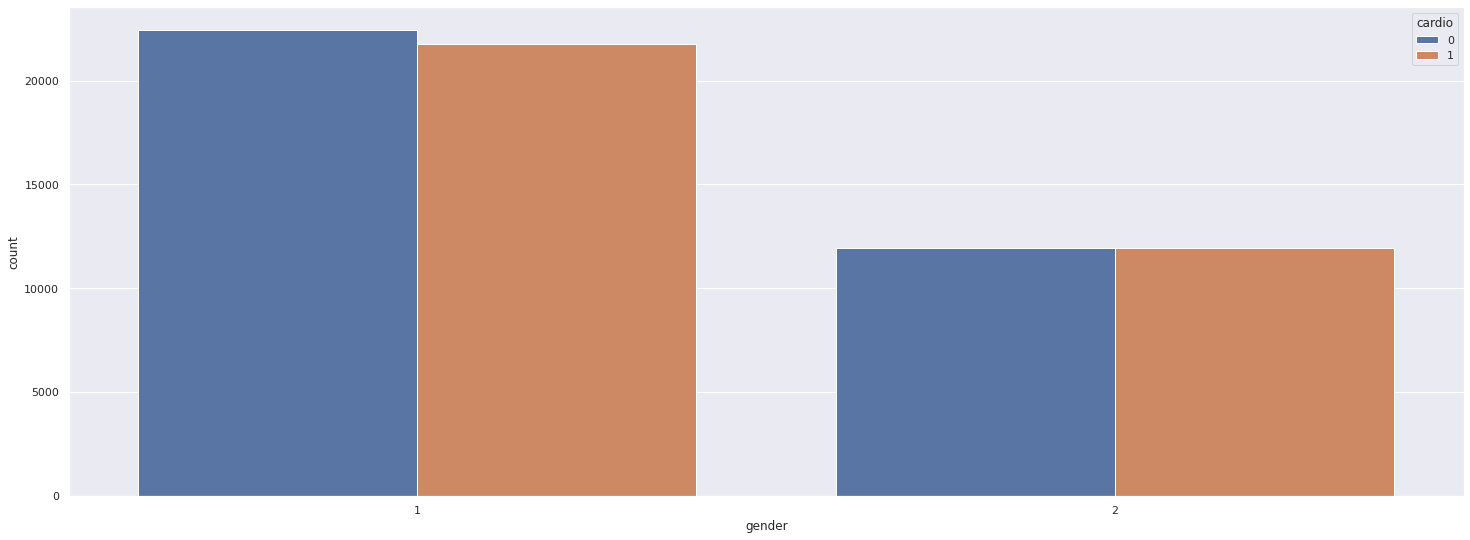

In [58]:
sns.countplot(x='gender', hue='cardio', data=df_train )

##### 5.2.14 - how more weith more risk
   True

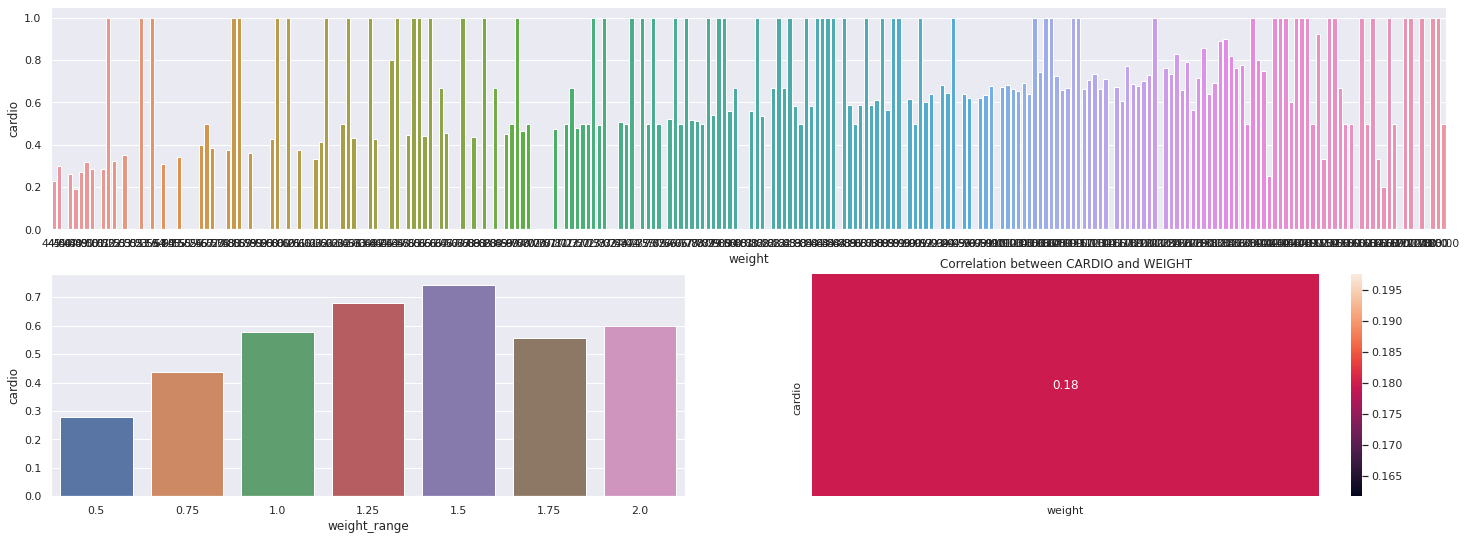

In [59]:
aux = df_train[['weight', 'cardio']].groupby('weight').mean().reset_index()
aux1 = df_train[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0:2])
sns.barplot(x='weight', y='cardio', data=aux);

plt.subplot(grid[1,0])
sns.barplot(x='weight_range', y='cardio', data=aux1);
                 
plt.subplot(grid[1,1])
plt.title('Correlation between CARDIO and WEIGHT')
pointb = pointbiserialr(df_train['weight'], df_train['cardio']).correlation
sns.heatmap(pd.DataFrame({'weight':pointb}, index=['cardio']), annot=True);

### 5.4 - Multivariate Analysis

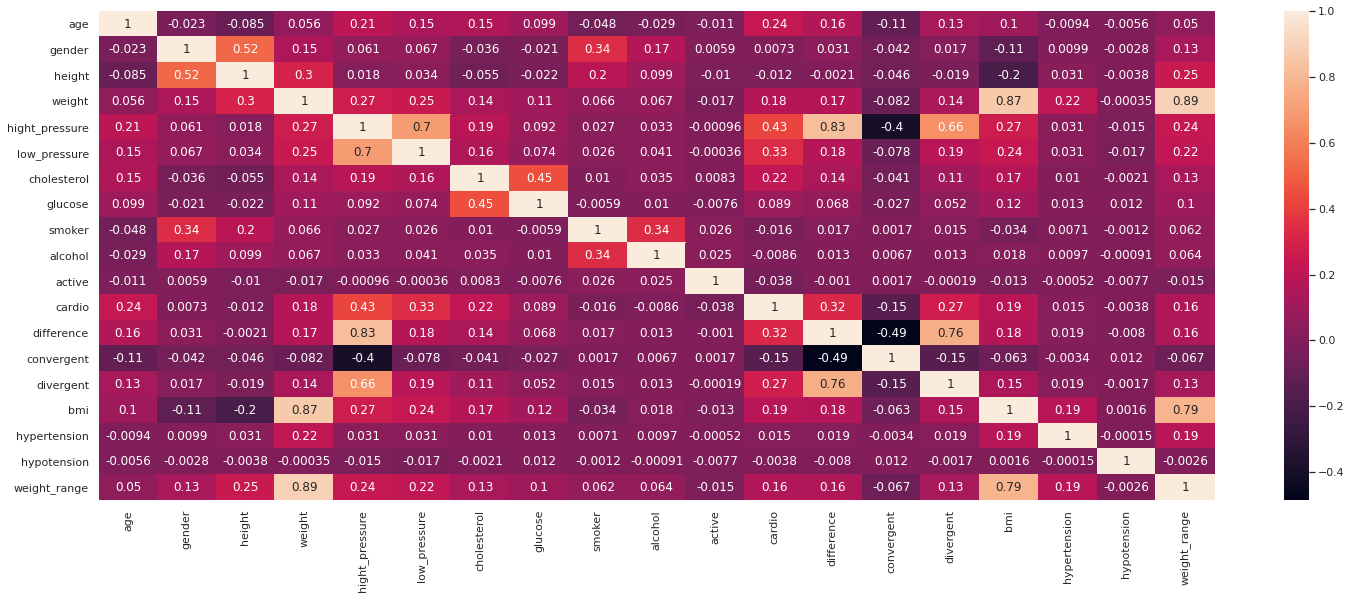

In [60]:
sns.heatmap(df_train.corr(), annot=True);

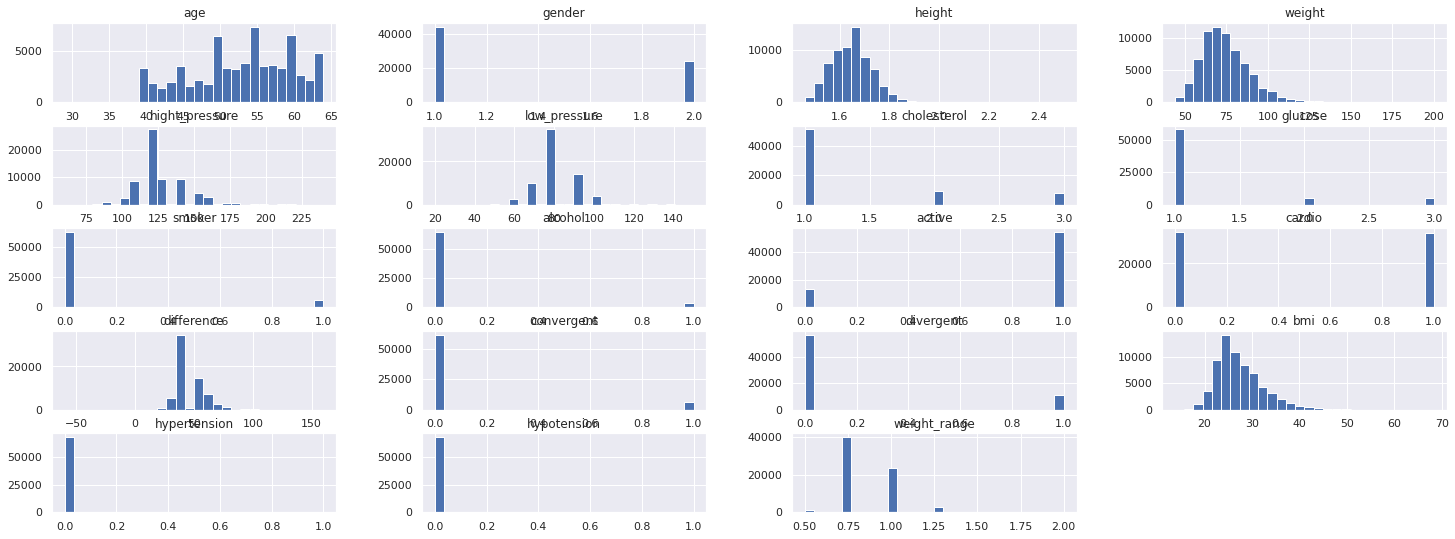

In [61]:
df_train.hist(bins=28);

## 6.0 - Data Preparation

### 6.1 - Split - Before Preparation

In [197]:
X = df_train.drop('cardio', axis=1).copy()
y = df_train['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [198]:
df_train = pd.concat([x_train, y_train], axis=1)
x_test = x_valid
y_test = y_valid

### 6.2 - Normalization

If the data is normal/gaussian distribution
<p>(item - média) / desvio padrão</p>

### 6.3 - Rescaling

If the data it's **NOT** gaussian distribution, gaussian is egual normal distribution

In [316]:
## The features that it's binary yet, it's not necessary transform
## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

mms = MinMaxScaler()
rs = RobustScaler()

# age
df_train['age'] = mms.fit_transform(df_train[['age']].values)
pickle.dump(mms, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/age_scaling.pkl', 'wb'))

# height         
df_train['height'] = rs.fit_transform(df_train[['height']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/height_scaling.pkl', 'wb'))

# weight
df_train['weight'] = rs.fit_transform(df_train[['weight']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/weight_scaling.pkl', 'wb'))

# low_pressure   
df_train['low_pressure'] = rs.fit_transform(df_train[['low_pressure']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/low_pressure_scaling.pkl', 'wb'))

#hight_pressure
df_train['hight_pressure'] = rs.fit_transform(df_train[['hight_pressure']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/hight_pressure_scaling.pkl', 'wb'))

# difference     
df_train['difference'] = rs.fit_transform(df_train[['difference']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/difference_scaling.pkl', 'wb'))

# bmi            
df_train['bmi'] = rs.fit_transform(df_train[['bmi']].values)
pickle.dump(rs, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/bmi_scaling.pkl', 'wb'))


### 6.4 - Transformation

#### 6.3.1 - Encoding

Transforming category data to numeric

In [317]:
le = LabelEncoder()

## Label encoding
# age
df_train['gender'] = le.fit_transform(df_train[['gender']].values)
pickle.dump(le, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/parameters/gender_encoder.pkl', 'wb'))

## Ordinal encoding
# age_range 
df_train['age_range'] = df_train['age_range'].map(
    {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})

# bmi_level
df_train['bmi_level'] = df_train['bmi_level'].map({
    'underweight':1, 'normal':2, 'overweight':3, 'obesity':4
})

#### 6.3.2 - Nature Transformation

Transforming the data to cycle nature

## 7.0 - Feature Selection

### 7.0 - Split

In [29]:
## Spliting after rescaling

X = df_train.drop('cardio', axis=1).copy()
y = df_train['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### 7.1 - Boruta

In [ ]:
#same pararameter from item 8.0
#x_boruta = x_train.values
#y_boruta = y_train.ravel()
#
#mdl = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)


In [ ]:
# Defining Boruta
#boruta = BorutaPy(mdl, n_estimators='auto', verbose=2, random_state=42).fit(x_boruta, y_boruta)

In [ ]:
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = x_train.iloc[:, cols_selected].copy()

In [ ]:
#x_train = x_train[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()
#x_valid = x_valid[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()

## 8.0 - Machine learning

### 8.1 - Baseline

The baseline is the "status quo", between **55%** and **65%** of **PRECISION** Score

### 8.2 - Random Forest

In [ ]:
mdl = RandomForestClassifier(n_estimators=150, random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_rf = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df_score_rf['accuracy_cv'] = mean(n_scores)
df_score_rf['accuracy_cv_std'] = std(n_scores)
df_score_rf

### 8.3 - GBDT

<a style="font-size:10px" href="https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/"> Font Coding</a>

In [438]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_gbdt = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df_score_gbdt['accuracy_cv'] = mean(n_scores)
df_score_gbdt['accuracy_cv_std'] = std(n_scores)
df_score_gbdt

,mdl_name,accuracy,precision,recall,split_before_scaling,date,obs,accuracy_cv,accuracy_cv_std
0,GradientBoostingClassifier(),0.738282,0.757053,0.694036,True,2020-10-19,All Data Features,0.730901,0.006219


### 8.4 - Logistic Regression

In [ ]:
mdl = LogisticRegression(random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_lr = metrics_score(y_valid, y_hat, mdl_name, True, "All Data Features")
df_score_lr['accuracy_cv'] = mean(n_scores)
df_score_lr['accuracy_cv_std'] = std(n_scores)
df_score_lr

### 8.5 - XGBClassifier

<a style="font-size:10px" href="https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/"> Font Coding</a>

In [ ]:
mdl = XGBClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_xgbc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Feature')
df_score_xgbc['accuracy_cv'] = mean(n_scores)
df_score_xgbc['accuracy_cv_std'] = std(n_scores)
df_score_xgbc

### 8.6 - KNClassifier

In [ ]:
mdl = KNeighborsClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
yhat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_knc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Feature')
df_score_knc['accuracy_cv'] = mean(n_scores)
df_score_knc['accuracy_cv_std'] = std(n_scores)
df_score_knc

### 8.7 - LGBMClassifier

In [ ]:
mdl = LGBMClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df_score_lgbmc = metrics_score(y_valid, y_hat, mdl_name, True, 'All Data Features')
df_score_lgbmc['accuracy_cv'] = mean(n_scores)
df_score_lgbmc['accuracy_cv_std'] = std(n_scores)
df_score_lgbmc

### 8.8 - Hyperparameters

In [ ]:
parameters = {'learning_rate':[0.01, 0.08], 
    'n_estimators':[100, 150],
    'subsample':[0.08, 0.1, 0.2, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'min_samples_split':[0.3, 0.6, 0.8, 2, 3, 4],
    'min_samples_leaf':[1, 2, 3, 4], 
    'max_depth':[3, 5, 10, 15, 20, 25]}

In [ ]:
MAX_EVALS = 50
df_hyper = pd.DataFrame(columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])

for i in range(MAX_EVALS):
    print(f'evals: {i}')
    
    hp = {k:sp(v, 1)[0] for k, v in parameters.items()}
    print(f'Hyperparameters: {hp}')
    mdl = GradientBoostingClassifier(
        learning_rate=hp['learning_rate'], n_estimators=hp['n_estimators'],
        subsample=hp['subsample'], min_samples_split=hp['min_samples_split'],
        min_samples_leaf=hp['min_samples_leaf'], max_depth=hp['max_depth'],
        loss='deviance', random_state=42
        ).fit(x_train, y_train)
    print('trained...')
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('crossvalidation finished')
    
    df_cv = pd.DataFrame([[mean(n_scores), std(n_scores), hp]], 
                        columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])
    
    print(df_cv)
    df_hyper = pd.concat([df_hyper, df_cv], axis=0)
    
df_hyper

### 8.9 - Final Model

In [448]:
final_model = GradientBoostingClassifier().fit(x_train, y_train)
#pickle.dump(final_model, open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'wb'))

## 9.0 - Metrics

### 9.1 - Validation

In [ ]:
## all scoring sbs == spliting before scaling
df_all_scores_sbs = pd.concat([df_score_rf, df_score_gbdt, df_score_lr, df_score_xgbc, df_score_knc, df_score_lgbmc], axis=0)
df_all_scores_sbs

In [ ]:
with open('score_cycle_02.pkl', 'rb') as file:
    df_score_pic = pickle.load(file)
    
df_all_scores_concat = pd.concat([df_score_pic, df_all_scores_sbs], axis=0)
df_all_scores_concat

### 9.2 - Cross Validation

In [445]:
## all scoring split before scaling

df_all_scores_cv = pd.concat([df_score_rf, df_score_gbdt, df_score_lr, df_score_xgbc, 
                              df_score_knc, df_score_lgbmc], axis=0)
# rename column 
df_all_scores_cv.columns = ['mdl_name', 'accuracy', 'precision', 'recall', 'split_before_scaling',
                            'date', 'obs', 'accuracy_cv', 'accuracy_cv_std']

# reordenation from columns
df_all_scores_cv[['mdl_name', 'accuracy', 'accuracy_cv', 'accuracy_cv_std', 'precision', 
                 'recall', 'split_before_scaling', 'date', 'obs']]

NameError: name 'df_score_rf' is not defined

**Gradient Boosting it's better**

In [ ]:
## Exporting result from cross validation
#with open('score_cycle_02_cv.pkl', 'wb') as file:
#    pickle.dump(df_all_scores_cv, file)

### 9.3 - Test Data

If the data is normal/gaussian distribution
<p>(item - média) / desvio padrão</p>

#### 9.2.1 - Rescaling

If the data it's **NOT** gaussian distribution, gaussian is egual normal distribution

In [439]:
## The features that it's binary yet, it's not necessary transform
## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

mms = MinMaxScaler()
rs = RobustScaler()

# age
x_test['age'] = mms.fit_transform(x_test[['age']].values)

# height         
x_test['height'] = rs.fit_transform(x_test[['height']].values)

# weight
x_test['weight'] = rs.fit_transform(x_test[['weight']].values)

# low_pressure   
x_test['low_pressure'] = rs.fit_transform(x_test[['low_pressure']].values)

#hight_pressure
x_test['hight_pressure'] = rs.fit_transform(x_test[['hight_pressure']].values)

# difference     
x_test['difference'] = rs.fit_transform(x_test[['difference']].values)

# bmi            
x_test['bmi'] = rs.fit_transform(x_test[['bmi']].values)

#### 9.2.2 - Transformation

#### 9.2.3 - Encoding

Transforming category data to numeric

In [440]:
le = LabelEncoder()

## Label encoding
# age
x_test['gender'] = le.fit_transform(x_test[['gender']].values)


## Ordinal encoding
# age_range 
x_test['age_range'] = x_test['age_range'].map(
    {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})

# bmi_level
x_test['bmi_level'] = x_test['bmi_level'].map({
    'underweight':1, 'normal':2, 'overweight':3, 'obesity':4
})

#### 9.2.4 - Modeling and Metrics

In [441]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_test)

df_score_gbdt_test = metrics_score(y_test, y_hat, mdl_name, True, "All Data Features")
df_score_gbdt_test

,mdl_name,accuracy,precision,recall,split_before_scaling,date,obs
0,GradientBoostingClassifier(),0.736827,0.753994,0.692956,True,2020-10-19,All Data Features


### 9.4 - Business Performance

In [443]:
cost_status_quo = 1000                         ## cost of each diagnostic with operators and machines
percentual_status_quo = (0.55+0.65)/2
revenue_status_quo = int((percentual_status_quo - 0.50)/0.05) * 500
result_status_quo = revenue_status_quo - cost_status_quo

cost_future = 0
standard = 0.006706
percentual_future = (0.752+0.765)/2
revenue_future = int((percentual_future - 0.50)/0.05) * 500  
result_model_future = revenue_future - cost_future   

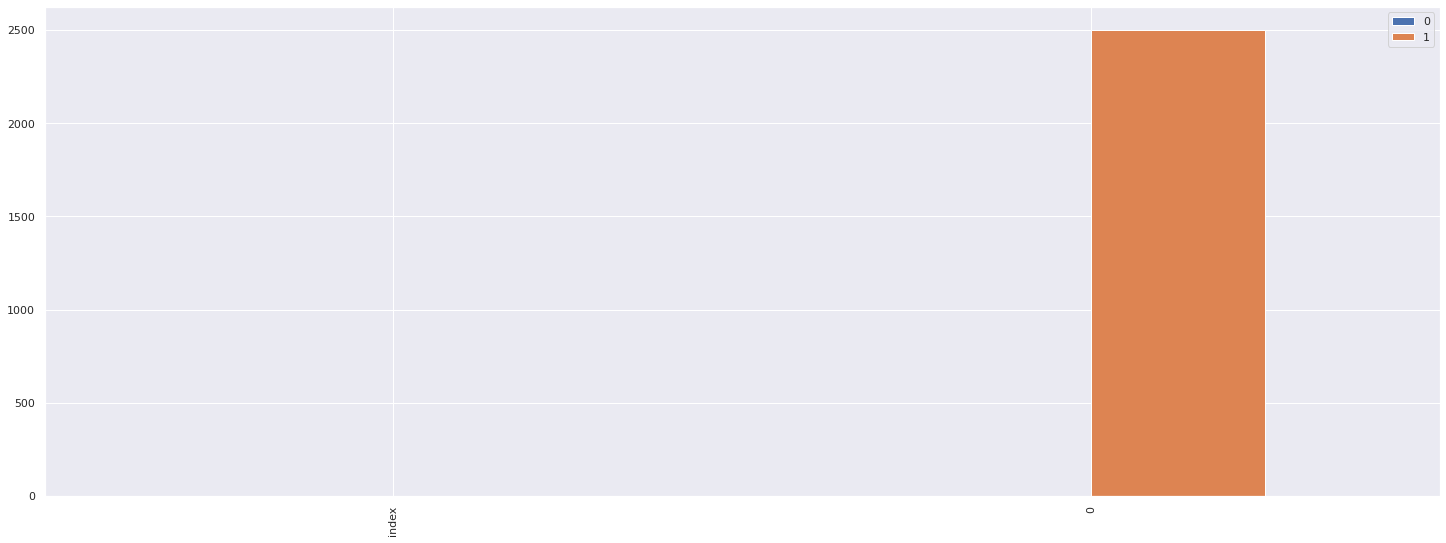

In [444]:
pd.concat([pd.Series(result_status_quo), pd.Series(result_model_future)]).reset_index().T.plot(kind='bar');

## 10.0 - Deploy

### 10.1 - Class

In [34]:
import pandas as pd
import numpy as np
import json
import pickle

# this file will be a handler "API"
class Cardio_Catch_Diseases(object):
    def __init__(self):
        self.home_path              = '/home/python/Documents/Projects/pa001_cardio_catch_diseases/'
        self.age_scaling            = pickle.load(open(self.home_path + 'parameters/age_scaling.pkl', 'rb'))
        self.bmi_scaling            = pickle.load(open(self.home_path + 'parameters/bmi_scaling.pkl', 'rb'))
        self.difference_scaling     = pickle.load(open(self.home_path + 'parameters/difference_scaling.pkl', 'rb'))
        self.height_scaling         = pickle.load(open(self.home_path + 'parameters/height_scaling.pkl', 'rb'))
        self.hight_pressure_scaling = pickle.load(open(self.home_path + 'parameters/hight_pressure_scaling.pkl', 'rb'))
        self.low_pressure_scaling   = pickle.load(open(self.home_path + 'parameters/low_pressure_scaling.pkl', 'rb'))
        self.weight_scaling         = pickle.load(open(self.home_path + 'parameters/weight_scaling.pkl', 'rb'))
        self.gender_encoder         = pickle.load(open(self.home_path + 'parameters/gender_encoder.pkl', 'rb'))


    
    def data_cleaning(self, df_train):
        '''df_train: is the input data from user on website'''


        # height - change centimeters to meters
        df_train['height'] = (df_train['height'] / 100)

        return df_train

    def feature_engineering(self, df_train):
        '''Get the dataframe from data cleaning and create a new features'''


        # feature engineering
        df_train['difference'] = df_train['hight_pressure'] - df_train['low_pressure']
        df_train['convergent'] = df_train['difference'].apply(lambda x: 1 if x <= 30 else 0)
        df_train['divergent'] = df_train['difference'].apply(lambda x: 1 if x >= 60 else 0)
        df_train['bmi'] = (df_train['weight']/(df_train['height'] * df_train['height']))
        df_train['bmi_level'] = df_train['bmi'].apply(lambda x: 
                                                      'underweight' if x <= 18.5 else
                                                      'normal'      if x >  18.5 and x <= 24.9 else
                                                      'overweight'  if x >= 25.0 and x <= 29.9 else
                                                      'obesity')
        df_train['hypertension'] = df_train.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
        df_train['hypotension'] = df_train.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)
        df_train['age_range'] = df_train['age'].apply(lambda x: 'age_0_50'    if x <= 50 
                                                           else 'age_51_59'   if x >= 51 and x <= 59 
                                                           else 'age_60_over' if x >= 60 
                                                           else x)

        df_train['weight_range'] = df_train['weight'].apply(
            lambda x:   0.50 if x <= 50  else
                        0.75 if x >= 51  and x <= 75 else
                        1.00 if x >= 76  and x <= 100 else
                        1.25 if x >= 101 and x <= 125 else
                        1.50 if x >= 126 and x <= 150 else
                        1.75 if x >= 151 and x <= 175 else 2.00)

        # Data Filtering rows, values or columns
        df_train = df_train.drop('id', axis=1)

        return df_train


    def data_rescaling(self, df_train):
        '''
        Rescaling data
        Return: json file with x_test data to input the prediction
        '''


        # Transforming data to will be in correct data scaler to input at model
        df_train['age']            = self.age_scaling.transform(df_train[['age']].values)
        df_train['height']         = self.height_scaling.transform(df_train[['height']].values)
        df_train['weight']         = self.weight_scaling.transform(df_train[['weight']].values)
        df_train['low_pressure']   = self.low_pressure_scaling.transform(df_train[['low_pressure']].values)
        df_train['hight_pressure'] = self.hight_pressure_scaling.transform(df_train[['hight_pressure']].values)
        df_train['difference']     = self.difference_scaling.transform(df_train[['difference']].values)
        df_train['bmi']            = self.bmi_scaling.transform(df_train[['bmi']].values)
        df_train['gender']         = self.gender_encoder.transform(df_train[['gender']].values)
        df_train['age_range']      = df_train['age_range'].map(
            {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})
        df_train['bmi_level']      = df_train['bmi_level'].map(
            {'underweight':1, 'normal':2, 'overweight':3, 'obesity':4})

        # Deleting target
        x_test = df_train.drop('cardio', axis=1).copy()
        #data_json = json.dumps(x_test.to_dict(orient='records')) # converto to json

        return x_test

### 10.2 - Input Simulation

In [134]:
import pandas as pd

def input_simulation():
    # inputs from user
    
    age = input('age: ')
    gender = int(input('gender: '))
    height = int(input('height: '))
    weight = float(input('weight: '))
    ap_hi = int(input('hight_pressure: '))
    ap_lo = int(input('low_pressure: '))
    cholesterol = int(input('cholesterol (1,2 or 3): '))
    gluc = int(input('glucose (1,2 or 3): '))
    smoke = int(input('smoker: '))
    alco = int(input('alcohol: '))
    active = input('active: ')

    # replacing columns names
    new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
               'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

    # getting data and converting to dataframe
    df_inputed = [[1, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, 0,]]
    df_train = pd.DataFrame(df_inputed, columns=new_col)

    # datatypes transformations
    df_train['age'] = df_train['age'].astype('int64')
    df_train['gender'] = df_train['gender'].astype('int64')
    df_train['height'] = df_train['height'].astype('int64')
    df_train['weight'] = df_train['weight'].astype('float64')
    df_train['hight_pressure'] = df_train['hight_pressure'].astype('int64') 
    df_train['low_pressure'] = df_train['low_pressure'].astype('int64') 
    df_train['cholesterol'] = df_train['cholesterol'].astype('int64')
    df_train['glucose'] = df_train['glucose'].astype('int64')
    df_train['smoker'] = df_train['smoker'].astype('int64') 
    df_train['alcohol'] = df_train['alcohol'].astype('int64')
    df_train['active'] = df_train['active'].astype('int64')
    df_train['cardio'] = df_train['cardio'].astype('int64')

    return json.dumps(df_train.to_dict(orient='records'))

### 10.2 - API / Handler

In [32]:
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from ccd.ccd import Cardio_Catch_Diseases
import json

# loading model trained from pickle file
with open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'rb') as file:
    model = pickle.load(file)

# initialized API
app = Flask(__name__)

@app.route('/ccd/predict', methods=['POST'])
def ccd_predict():
    '''
    ccd: Cardio Catch Diseases
    This function it will be create the API request, where the user will be input the user data that 
    will used to data_cleaning(), data_engineering(), data_scaler() 
    this functions will be return the dataframe 'x_est', that will be used to predict
    Return: Prediction "array"
    '''
    
    test_json = request.get_json()
        
    if test_json:
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate CCD class
        pipeline = Cardio_Catch_Diseases()
        # cleaning data
        test_raw_cleaned = pipeline.data_cleaning(test_raw)
        # creating derivates to new features
        test_raw_features = pipeline.feature_engineering(test_raw_cleaned)        
        
        # preparing data to model
        test_raw_selected = pipeline.data_rescaling(test_raw_features)
        
        y_hat = model.predict(test_raw_selected)
        test_raw['prediction'] = y_hat.copy()
        return test_raw.to_json(orient='records')
    
    else:
        return Response( "{}", status=200, mimetype='application/json')

    
if __name__=='__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'ccd'

### 10.2 - API Request Tester

In [303]:
import requests

# Input data user
data = input_simulation()

# API request
url = "http://0.0.0.0:5000/ccd/predict"
header = {'Content-type': 'application/json'}

response_ccd = requests.post(url, data=data, headers=header)
print(f'Status Code: {response_ccd.status_code}')

df_response = pd.DataFrame(response_ccd.json(), columns=response_ccd.json()[0].keys())

# Loading json to Dataframe
df_new = pd.DataFrame(json.loads(data))

# converting to back the original datatype
df_new['age'] = df_new['age'] * 365

# getting prediction
df_new['cardio'] = df_response['cardio'].copy()

# getting current time in seconds since the Epoch.
# convert to normal date use time.ctime(time.time())
df_new['id'] = time.time()

# Insert into database
insert_database_values(df_new)

df_response

age: 35
gender: 1
height: 175
weight: 93
hight_pressure: 130
low_pressure: 85
cholesterol (1,2 or 3): 1
glucose (1,2 or 3): 1
smoker: 0
alcohol: 1
active: 1
Status Code: 200


,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio,difference,convergent,divergent,bmi,bmi_level,hypertension,hypotension,age_range,weight_range,prediction
0,1,35,1,1.75,93.0,130,85,1,1,0,1,1,0,45,0,0,30.367347,obesity,0,0,age_0_50,1.0,0
